In [137]:
import torch 
import matplotlib.pyplot as plt

In [81]:
SEED = 2147483647

In [139]:
bigrams = {}
words = open('names.txt').read().splitlines()
chars = sorted(list(set(''.join(words))))
N = torch.zeros((27, 27), dtype=torch.int32)
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}

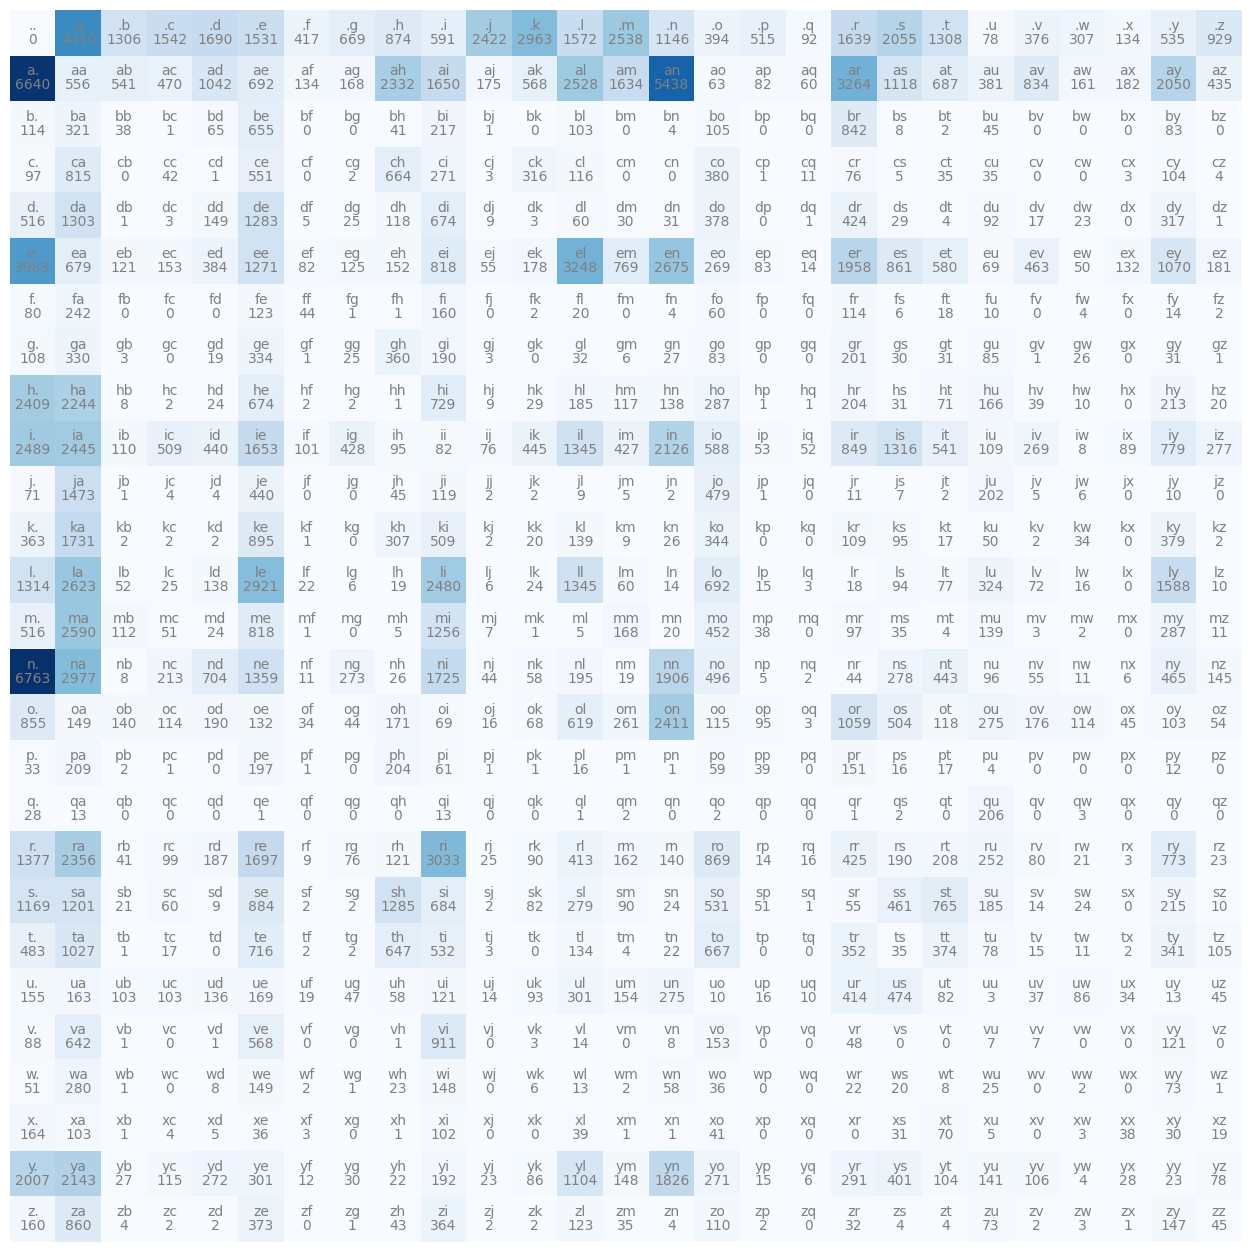

In [140]:
# Matplotlib plots are displayed inline within the notebook itself, instead of opening in a separate window.
%matplotlib inline 

for w in words:
    chs = ['.'] + list(w) + ['.'] # Introducing explicit boundaries: We add this dot to the beginning and the end of the char to avoid affecting the bigram count matrix by contributing only to the column sums and not to the row sums.
    for ch1, ch2 in zip(chs, chs[1:]):
        N[stoi[ch1], stoi[ch2]] += 1

plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='gray')
        plt.text(j, i, N[i, j].item(), ha='center', va='top', color='gray')     
plt.axis('off')
plt.show()

In the below code we explicitely convert the N[0] to float, but we will get the same result even if we don't convert it since:


When performing division (/) between integer tensors, PyTorch automatically promotes the output type to torch.float32. 
We just did it here for clarity and avoiding unexpected type issues.

In [141]:
# first row, and we want to sample from this
N[0]
p = N[0].float() # convert to float since we want to normalize these counts
p = p / p.sum()
p # this is the probability distribution, we want to choose a random sample from it

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

Why using the Generator? to have a deterministic behavior, get the exact same result whenever we run the code.

What Happens If You Don't Pass the Generator?
If you do not pass a generator (generator=g) to torch.rand(3), PyTorch will use the global random number generator instead of the manually seeded generator g. This means:

- The random numbers generated in torch.rand(3) will be different unless the global random seed was set earlier.

- Every time you run the code, it might produce different values because it will rely on the default global RNG state.

- If you had used the manually seeded generator g, the output would be deterministic (always the same random values for the given seed).


In [142]:
# Evey time I run the below code, I get a different result.
p = torch.rand(3)
p = p / p.sum()
p

tensor([0.3762, 0.3774, 0.2464])

In [143]:
# Every time I run the code, I get the same result.
g = torch.Generator().manual_seed(SEED)
p = torch.rand(3, generator=g)
p = p / p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

```torch.multinomial``` will always return the indices as long as the p is a probability distribution.

Here, we expect 60% of the samples to have index 0, and 30% to have index 1, and 10% to have index 2.

In [144]:
torch.multinomial(p, num_samples=20, replacement=True, generator=g)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [145]:
p = N[0].float()
p =  p / p.sum()
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos[idx]

'h'

These samples are terrrible, why?

This is what a bigram is, as terrible as it is.

In [ ]:
for i in range(10):
    ix = 0
    W2 = []
    while True:
        p = N[ix].float()
        p = p /  p.sum()
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = itos[ix]
        W2.append(sampled_char)
        if ix == 0:
            break

    print(''.join(W2))

deen.
pereltwnigua.
sadryrolyiniydavesole.
rish.
be.
ka.
nn.
jo.
s.
t.


In [ ]:
# Instead of sampling from N, we want to sample from a uniform distribution so that each character has the same probability.

for i in range(10):
    ix = 0
    W2 = []
    while True:
        p = torch.ones(27) / 27.0
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = itos[ix]
        W2.append(sampled_char)
        if ix == 0:
            break

    print(''.join(W2))

aozqabzgvonxwfjpndkpedeshpqtrzgawbl.
deybiiictjfsihquqzzd.
egehkewsjsb.
gjolcvltnyqbensbylyzuwpuqwgzmuhe.
ggqqjqup.
duiijepkeqibbzttgbtnkzhq.
vrmyqgbwtyudzfgoodagaigsoszgkidqbcwltuzqqrqypihmhawpryhrfcnivofayn.
xxoejdppejhdckodwvmbtrvjkgalqkdtlmwugcyhdnfkpyvphcfet.
ecfiljouyxhglanwkrol.
mkqoybqi.


Create the P matrix where every single row contains the probabilities. the probability distribution for the next character where we have the current character.

In [148]:
P = N.float()
P.sum() # sum of all the items in the matrix N, but we want to divide all the rows by their respective sums
print(P.sum(dim=0, keepdim=True).shape)  # summing across the first dimention
print(P.sum(dim=0, keepdim=False).shape) # setting the keepdim to False squeezes the respected dimention

# We don't want the sum across the rows, we want it across the columns so we must set the dim to 1
print(P.sum(1, keepdim=True))
print(P.sum(0, keepdim=True))

# Sth interesting is that the sum over rows is euqal to the sum over columns, WHY?
# This follows from a fundamental counting principle:
    # Every occurrence of a bigram (a → b) contributes +1 to both:
    # The row sum of a (since a is the first character in the bigram).
    # The column sum of b (since b is the second character in the bigram).

# Thus, the total number of times characters are used as first letters in bigrams is the same as the total number of times they are used as second letters in bigrams.

torch.Size([1, 27])
torch.Size([27])
tensor([[32033.],
        [33885.],
        [ 2645.],
        [ 3532.],
        [ 5496.],
        [20423.],
        [  905.],
        [ 1927.],
        [ 7616.],
        [17701.],
        [ 2900.],
        [ 5040.],
        [13958.],
        [ 6642.],
        [18327.],
        [ 7934.],
        [ 1026.],
        [  272.],
        [12700.],
        [ 8106.],
        [ 5570.],
        [ 3135.],
        [ 2573.],
        [  929.],
        [  697.],
        [ 9776.],
        [ 2398.]])
tensor([[32033., 33885.,  2645.,  3532.,  5496., 20423.,   905.,  1927.,  7616.,
         17701.,  2900.,  5040., 13958.,  6642., 18327.,  7934.,  1026.,   272.,
         12700.,  8106.,  5570.,  3135.,  2573.,   929.,   697.,  9776.,  2398.]])


Is it possible to take a (27, 27) matrix; P in this case, and divide it by (27, 1) array?


For broadcasting in Pytorch, When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

In our case we have the two tensors with the below dimentions:

27, 27

27, 1


If we start from right, 27 is not equal to 1 but one of them is 1 (it copies it 27 times and then perform the element wise division), so we can move to the next element which are equal. So, in our case this operation 

```P / P.sum(dim=1, keepdim=True)```

is broadcastable.

In [149]:
P = N.float()
P = P / P.sum(dim=1, keepdim=True)
assert P[0].sum() == torch.tensor(1.)

In [150]:
for i in range(10):
    ix = 0
    res = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, generator=g).item()
        char = itos[ix]
        res.append(char)
        if ix == 0:
            break
    print(''.join(res))

le.
l.
mragi.
celadahereneyuerlizeniquiai.
kowasiarey.
min.
t.
zolabesh.
beriamein.
chs.


In [ ]:
for i in range(10):
    ix = 0
    W2 = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = itos[ix]
        W2.append(sampled_char)
        if ix == 0:
            break

    print(''.join(W2))

heicli.
e.
haynolueana.
biyusonylerri.
brarte.
ka.
ayaiensan.
jeshon.
rayn.
dan.


What would happen if we set the keepdim to False?

P = N.float()           # shape: (28, 28)

P = P / P.sum(dim=1)    # shape: (28)


These two tensors are broadcastable, and the result shape is (28, 28), but the sum of the items in a row is not equal to 1. This is because we are normalizing columns instead of normalizing the rows.

In [ ]:
P = N.float()
P = P / P.sum(dim=1)
print(P[0].sum())

for i in range(10):
    ix = 0
    W2 = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        sampled_char = itos[ix]
        W2.append(sampled_char)
        if ix == 0:
            break

    print(''.join(W2))

tensor(7.0225)
grqunawthaviugwfgwhwsqulyowyn.
jexxahzliffa.
shabebddimadhuqubuw.
khastymemyyvvicerbruffffrowiggwydouvaxxthnzzh.
ens.
quequmiye.
v.
zwustaheynsthyfrighd.
jatownywacqumuchkwuzolychueuuesthuwaquberysh.
mstonissuzyxzzubduwidezaruzh.


The difference between ```P /= P.sum(dim=1, keepdim=True)``` and ```P = P / P.sum(dim=1, keepdim=True)``` ?

The second one is the in-place operation which is faster since it doesn't make a copy of the data.

In [ ]:
P = N.float()
P /= P.sum(dim=1, keepdim=True)

for i in range(20):
    ix = 0
    W2 = []
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, generator=g).item()
        W2.append(itos[ix])
        if ix == 0:
            break
    print(''.join(W2))

ke.
di.
lehanainen.
neylen.
kethn.
siyma.
n.
a.
ssthal.
zigin.
enngyorviyn.
ghn.
rephallle.
baholiaen.
ton.
aa.
ba.
ll.
fademarishickamegale.
imoduxanaylalieylle.


Until now, we have trained a bigram language model whose parameters are the items of the tensor P.

Now we need to measure the quality of this model.

In [156]:
log_likelihood = 0.0
n = 0
# for w in words:
for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob) # the more negative, the worse 
        log_likelihood += logprob
        n += 1 
        print(f"{ch1}{ch2}: {prob:.4f}, {logprob:.4f}")

print(log_likelihood) # when all the probabilities are 1, the log of those probs is 0, and the log_liklihood is 0 too which is the ideal, but the more negative it become, it is undesirable!
neg_log_likelihood = -log_likelihood
normalized_nll = neg_log_likelihood / n  # get the average log likelihood, the lower it is, the better
print(neg_log_likelihood)
print(normalized_nll)

.a: 0.1377, -1.9829
an: 0.1605, -1.8296
nd: 0.0384, -3.2594
dr: 0.0771, -2.5620
re: 0.1336, -2.0127
ej: 0.0027, -5.9171
jq: 0.0000, -inf
q.: 0.1029, -2.2736
tensor(-inf)
tensor(inf)
tensor(inf)


## Model Smoothing 
To make sure we won't have 0 probabilities in our model distribution, we will add 1 to all of the items of N
The larger the number we add, the more uniform the probability distribution

In [157]:
P = (N+1).float()
P /= P.sum(dim=1, keepdim=True)

In [158]:
log_likelihood = 0.0
n = 0
# for w in words:
for w in ["andrejq"]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob) # the more negative, the worse 
        log_likelihood += logprob
        n += 1 
        print(f"{ch1}{ch2}: {prob:.4f}, {logprob:.4f}")

print(log_likelihood) # when all the probabilities are 1, the log of those probs is 0, and the log_liklihood is 0 too which is the ideal, but the more negative it become, it is undesirable!
neg_log_likelihood = -log_likelihood
normalized_nll = neg_log_likelihood / n  # get the average log likelihood, the lower it is, the better
print(neg_log_likelihood)
print(normalized_nll)

.a: 0.1376, -1.9835
an: 0.1604, -1.8302
nd: 0.0384, -3.2594
dr: 0.0770, -2.5646
re: 0.1334, -2.0143
ej: 0.0027, -5.9004
jq: 0.0003, -7.9817
q.: 0.0970, -2.3331
tensor(-27.8672)
tensor(27.8672)
tensor(3.4834)


Difference between ```torch.tensor``` and ```torch.Tensor```:

the first one infers the data type automatically while the second one returns a ```torch.floatTensor```
It is advised to use the ````torch.tensor```

In [ ]:
# how to build xenc?
X, Y = [],  []

for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        X.append(stoi[ch1])
        Y.append(stoi[ch2])
    

xenc = F.one_hot(torch.tensor(X), num_classes=27)
xenc = F.one_hot(torch.tensor(Y), num_classes=27)
xenc.shape


torch.Size([228146, 27])

In [ ]:
# Create the training set of all the bigrams

X, Y = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        X.append(ix1)
        Y.append(ix2)

X = torch.tensor(X)
Y = torch.tensor(Y)
X
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [ ]:
import torch.nn.functional as F

xenc = F.one_hot(X, num_classes=27).float() # input to the NN: one-hot encoding
yenc = F.one_hot(Y, num_classes=27).float()

torch.float32

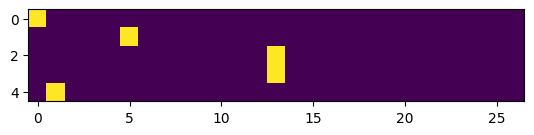

In [36]:
plt.imshow(xenc)
xenc.dtype # when feeding the input data to the NNs, we want the data to be of type float not integers!

Let's just define a sinle neuron for now

In [52]:
W = torch.randn((27, 1), generator=g)
xenc @ W # @ is a matrix multiplication in Pytorch

tensor([[-0.2473],
        [-1.4539],
        [-0.8063],
        [-0.8063],
        [-1.8178]])

In [169]:
W = torch.randn((27, 27))
xenc @ W 

tensor([[ 1.0919,  0.7000,  0.7619, -1.2755,  0.6554, -2.0202,  1.0222, -0.6758,
         -1.6652,  1.3017, -0.4563, -0.0960, -0.5379,  0.7286, -0.7462,  1.3966,
         -0.7726,  0.2185,  0.3071,  0.4103,  0.3910, -0.3429,  1.8974,  0.2159,
         -1.5042, -1.6030, -0.0179],
        [ 1.1506, -1.5443, -1.6845, -0.2472, -0.7205, -0.3551,  0.8657,  1.7191,
         -0.3533, -0.8400,  0.6582, -0.6754, -0.2839, -2.1739,  0.1321, -0.0394,
         -0.6984, -1.6020, -0.3517, -0.3577, -0.5542, -0.7772, -1.0981,  0.9290,
         -0.6389,  0.3317, -0.5202],
        [-0.9939, -0.3942, -0.4925, -0.3621,  1.0438,  1.1646,  0.1900,  0.0707,
         -2.5618,  1.0896,  0.4605,  0.8476, -0.6414,  0.6285,  1.5733, -1.0286,
          0.8804,  0.6814, -1.2164, -0.6297, -1.2501,  1.0356, -2.8827, -1.0269,
          1.6526, -0.6178, -0.4708],
        [-0.9939, -0.3942, -0.4925, -0.3621,  1.0438,  1.1646,  0.1900,  0.0707,
         -2.5618,  1.0896,  0.4605,  0.8476, -0.6414,  0.6285,  1.5733, -1.0286

In [170]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [171]:
W[:, 13]

tensor([ 0.7286, -0.7797,  0.0612, -1.0401, -1.3128, -2.1739,  0.0603, -0.9159,
         1.5664, -1.2433,  1.1177, -1.6367, -0.9476,  0.6285,  0.8171, -1.3392,
        -0.5288, -1.0115,  0.9045, -2.1700,  1.2610,  0.2568, -1.2345,  2.0403,
         0.5649, -0.0724,  0.6684])

In [172]:
(xenc[3] * W[:, 13]).sum()

tensor(0.6285)

In [173]:
(xenc @ W)[3, 13] # the firing rate of the 13th neuron looking at the 3rd input

tensor(0.6285)

In [174]:
logits = (xenc @ W) # log-counts
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs

tensor([[0.0719, 0.0486, 0.0517, 0.0067, 0.0465, 0.0032, 0.0671, 0.0123, 0.0046,
         0.0887, 0.0153, 0.0219, 0.0141, 0.0500, 0.0114, 0.0976, 0.0111, 0.0300,
         0.0328, 0.0364, 0.0357, 0.0171, 0.1610, 0.0300, 0.0054, 0.0049, 0.0237],
        [0.1107, 0.0075, 0.0065, 0.0274, 0.0170, 0.0246, 0.0833, 0.1955, 0.0246,
         0.0151, 0.0677, 0.0178, 0.0264, 0.0040, 0.0400, 0.0337, 0.0174, 0.0071,
         0.0246, 0.0245, 0.0201, 0.0161, 0.0117, 0.0887, 0.0185, 0.0488, 0.0208],
        [0.0092, 0.0167, 0.0151, 0.0173, 0.0704, 0.0794, 0.0300, 0.0266, 0.0019,
         0.0737, 0.0393, 0.0578, 0.0131, 0.0465, 0.1195, 0.0089, 0.0598, 0.0490,
         0.0073, 0.0132, 0.0071, 0.0698, 0.0014, 0.0089, 0.1294, 0.0134, 0.0155],
        [0.0092, 0.0167, 0.0151, 0.0173, 0.0704, 0.0794, 0.0300, 0.0266, 0.0019,
         0.0737, 0.0393, 0.0578, 0.0131, 0.0465, 0.1195, 0.0089, 0.0598, 0.0490,
         0.0073, 0.0132, 0.0071, 0.0698, 0.0014, 0.0089, 0.1294, 0.0134, 0.0155],
        [0.0395, 0.0620,

In [175]:
probs[0]

tensor([0.0719, 0.0486, 0.0517, 0.0067, 0.0465, 0.0032, 0.0671, 0.0123, 0.0046,
        0.0887, 0.0153, 0.0219, 0.0141, 0.0500, 0.0114, 0.0976, 0.0111, 0.0300,
        0.0328, 0.0364, 0.0357, 0.0171, 0.1610, 0.0300, 0.0054, 0.0049, 0.0237])

In [ ]:
# How to build the xenc and yenc ?
X, Y = [], []

for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        X.append(ix1)
        Y.append(ix2)
    
xenc =  F.one_hot(torch.tensor(X), num_classes=27).float()
yenc =  F.one_hot(torch.tensor(Y), num_classes=27).float()

In [ ]:
nlls = torch.zeros(5)

for i in range(5):
    x = X[i].item()
    y = Y[i].item()
    print('-------')
    print(f'bigram example {i + 1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print(f'Input to the neural net: {x}')
    print(f'Output probabilities from the neural net: {probs[i]}')
    print(f'Label: {y}')
    p = probs[i, y]
    print(f'Probability assigned by the net to the correct character: {p.item()}')
    logp = torch.log(p)
    print('Log Likelihood: ', logp.item())
    nll = - logp
    print(f'Negative Log Likelihhod: {nll.item()}')
    nlls[i] = nll

print('=======')
print(f"Average negative log likelihood, i.e. loss = {nlls.mean().item()}")

-------
bigram example 1: .e (indexes 0, 5)
Input to the neural net: 0
Output probabilities from the neural net: tensor([0.0719, 0.0486, 0.0517, 0.0067, 0.0465, 0.0032, 0.0671, 0.0123, 0.0046,
        0.0887, 0.0153, 0.0219, 0.0141, 0.0500, 0.0114, 0.0976, 0.0111, 0.0300,
        0.0328, 0.0364, 0.0357, 0.0171, 0.1610, 0.0300, 0.0054, 0.0049, 0.0237])
Label: 5
Probability assigned by the net to the correct character: 0.003202337073162198
Log Likelihood:  -5.743874549865723
Negative Log Likelihhod: 5.743874549865723
-------
bigram example 2: em (indexes 5, 13)
Input to the neural net: 5
Output probabilities from the neural net: tensor([0.1107, 0.0075, 0.0065, 0.0274, 0.0170, 0.0246, 0.0833, 0.1955, 0.0246,
        0.0151, 0.0677, 0.0178, 0.0264, 0.0040, 0.0400, 0.0337, 0.0174, 0.0071,
        0.0246, 0.0245, 0.0201, 0.0161, 0.0117, 0.0887, 0.0185, 0.0488, 0.0208])
Label: 13
Probability assigned by the net to the correct character: 0.003984399605542421
Log Likelihood:  -5.525368690490723

Optimiztion

In [ ]:
W = torch.randn((27, 27), requires_grad=True, generator=g)

# forward pass
xenc = F.one_hot(X, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
train_loss = -probs[torch.arange(5), Y].log().mean()


In [ ]:
# backward pass
W.grad = None # set the gradients to 0
train_loss.backward()

In [ ]:
print(train_loss)

tensor(3.2465, grad_fn=<NegBackward0>)


In [79]:
W.data += -0.1 * W.grad

In [ ]:
print(train_loss)

tensor(4.3416, grad_fn=<NegBackward0>)


In [95]:
len(words)

32033

Equivalent of Model Smoothing in Gradient Descent:
Initialize W in a way so that W will be centralize near 0 so it would be smoother.

This is the idea of regularization, adding a gravity to the W, and force it to be 0.


In [ ]:
nb_epoch = 100
X, Y = [], []

# create the dataset
for w in words:
    chars = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        X.append(ix1)
        Y.append(ix2)

X = torch.tensor(X)
Y = torch.tensor(Y)

xenc = F.one_hot(X, num_classes=27).float()
W = torch.randn((27, 27), generator=g, requires_grad=True)

nll = 0.0
lr = 100

for e in range(nb_epoch):
    # forward pass
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    train_loss = -probs[torch.arange(xenc.shape[0]), Y].log().mean()
    print(train_loss.item()) # it was good that you actually saw this, since we are not back propagating and we are not updating the parameters!
    nll += train_loss.item()

    # backward
    W.grad = None
    train_loss.backward()

    # update the parameters
    W.data += -lr * W.grad

3.838496685028076
3.169630765914917
2.933485507965088
2.819108247756958
2.744035005569458
2.708911180496216
2.651496648788452
2.6304304599761963
2.6135220527648926
2.61604905128479
2.5821659564971924
2.575084686279297
2.5686323642730713
2.5794734954833984
2.5526413917541504
2.5496912002563477
2.5473647117614746
2.5605502128601074
2.536816358566284
2.534959077835083
2.534555196762085
2.548440456390381
2.526125192642212
2.5248196125030518
2.52547025680542
2.539944648742676
2.518343687057495
2.5175046920776367
2.518848180770874
2.5338220596313477
2.512617349624634
2.5120949745178223
2.513932466506958
2.529276132583618
2.5083067417144775
2.507978916168213
2.5101776123046875
2.525789499282837
2.50496768951416
2.504761219024658
2.5072267055511475
2.52303409576416
2.502312421798706
2.5021843910217285
2.5048491954803467
2.520801067352295
2.500152826309204
2.50007963180542
2.502894639968872
2.518955707550049
2.4983623027801514
2.4983301162719727
2.5012595653533936
2.5174038410186768
2.496855735

In [ ]:
X, Y = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        X.append(ix1)
        Y.append(ix2)

X = torch.tensor(X)
Y = torch.tensor(Y)
num = X.nelement()
print("Number of elements: ", num)

# Initialize the network
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g, requires_grad=True)

Number of elements:  228146


```torch.arange(prob.size(0))```: Creates an array of indices [0, 1, 2, ..., 228145], representing each row.


In [ ]:
# Gradient Descent 
for k in range(100):
    # forward pass
    xenc = F.one_hot(X, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)
    train_loss = -probs[torch.arange(num), Y].log().mean() + 0.01 * (W**2).mean() #regularization, pushes W to be 0
    print(train_loss.item())

    # backward pass
    W.grad = None
    train_loss.backward()

    # update
    W.data += -50 * W.grad # 0.1 is the learning rate

3.1852657794952393
3.0345191955566406
2.9360949993133545
2.865769863128662
2.8133678436279297
2.772705316543579
2.7400193214416504
2.7130041122436523
2.69020414352417
2.6706669330596924
2.653740882873535
2.6389591693878174
2.6259684562683105
2.614489793777466
2.6042962074279785
2.5952000617980957
2.587045192718506
2.5796990394592285
2.573052406311035
2.5670125484466553
2.5615005493164062
2.5564513206481934
2.5518083572387695
2.547525405883789
2.5435614585876465
2.5398828983306885
2.5364601612091064
2.533268690109253
2.5302863121032715
2.5274946689605713
2.5248775482177734
2.5224199295043945
2.520108461380005
2.517932415008545
2.515880823135376
2.513943910598755
2.5121140480041504
2.5103821754455566
2.508741855621338
2.5071866512298584
2.5057106018066406
2.504307985305786
2.5029733180999756
2.5017027854919434
2.5004920959472656
2.4993369579315186
2.4982337951660156
2.4971797466278076
2.49617075920105
2.4952054023742676
2.4942798614501953
2.4933924674987793
2.4925403594970703
2.491721868

In [2]:
import torch 

import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for i, ch in stoi.items()}
print(stoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


Build the Dataset for the Neural Network

In [4]:
X, Y = [], []
block_size = 3 # How many characters do we take to predict the next character?

for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [313]:
num_input = X.shape[0]
num_labels = len(stoi)

In [314]:
# The Nueral Net that takes Xs and predict the Y
embed_dimention = 30
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((len(stoi), embed_dimention), generator=g, requires_grad=True)

embed = C[X]

# We need to reshape the embeddings to be of size (num_inputs, 3*30)
# There are several ways for doing this:
# 1) Using torch.cat and torch.unbind
torch.cat(torch.unbind(embed, 1), 1).shape

# 2) using .view function which is efficient (read this blog post: https://blog.ezyang.com/2019/05/pytorch-internals/)
embed = embed.view(-1, 90) # why -1? it is same as embed.shape[0]

In [ ]:
W1 = torch.randn((90, 128), generator=g, requires_grad=True)
b1 = torch.randn((128), requires_grad=True, generator=g)
W1 = torch.tanh(embed @ W1 + b1)

In [ ]:
W2 = torch.randn((128, num_labels))
b2 = torch.randn(num_labels)
logits = W1 @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
train_loss = -probs[torch.arange(num_input), Y].log().mean()
train_loss = F.cross_entropy(logits, Y)
train_loss

tensor(23.6419, grad_fn=<NllLossBackward0>)

In [ ]:
parameters = [C, W1, W2, b1, b2]
for p in parameters:
    p.requires_grad = True

for _ in range(10):
    # mini batch construct
    ix = torch.randint(0, num_input, (32,))
    # Forward Pass
    embed = C[X[ix]].view(-1, 90)
    W1 = torch.tanh(embed @ W1 + b1)
    logits = W1 @ W2 + b2
    train_loss = F.cross_entropy(logits, Y[ix])
    print(train_loss.item())

    # Backward pass
    for p in parameters:
        p.grad = None
    train_loss.backward()

    # Update Parameters
    for p in parameters:
        p.data += -0.1 * p.grad

19.990808486938477
23.390918731689453
27.736879348754883
22.202529907226562
20.36097526550293
19.56293296813965
20.17351531982422
22.418376922607422
16.30136489868164
16.504384994506836


What we did so far?

We want to use three characters instead of one for predicting the next character:

How should we build the train dataset? We need to build the X, Y

the expected size of the X must be: (num_samples, context_window) and the Y size must be (num_sample, 1)

Let's build this step by step:


In [246]:
import torch.nn.functional as F

In [ ]:
# read the file and store the words
# Get the unique characters with just one line of code
# Build the char to index dict and vice versa
# Now, we need to build the X, and Y with respect to the context window which is a hyperparameter iteself
# Next step would be to create the parameters (Embeddings, hidden layer, and output layer) and set their require_grads to True
# Now, it's time to implement the forward pass

context_size = 3
n_embed = 30
n_hidden = 128
learning_rate = 0.05
g = torch.Generator().manual_seed(27)

X, Y = [], []

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))

stoi = {ch: ix + 1 for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}

for w in words:
    context = [0] * context_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)
num_input =  X.shape[0]
num_classes = len(stoi)

# Creating parameters
E = torch.randn((num_classes, n_embed), generator=g)
W1 = torch.randn((context_size * n_embed, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, num_classes), generator=g)
b2 = torch.randn((num_classes), generator=g)
params = [E, W1, W2, b1, b2]

for p in params:
    p.requires_grad = True

In [ ]:
# Forward Pass
embeds = E[X].view((-1, n_embed * context_size))
h1 = torch.tanh(embeds @ W1 + b1)
logits = h1 @ W2 + b2
train_loss = F.cross_entropy(logits, Y)
print("Loss is: ", train_loss.item())

# backward pass
for p in params:
    p.grad = None
train_loss.backward()

# Update the parameters
for p in params:
    p.data += -learning_rate * p.grad

Loss is:  20.758621215820312


# How to determine the best learning rate?

First we play around with some learning rates to find the stable region, in our case it is between 0.001 and 1 (the loss when lr=1 is terrrible and unstable)

Then you have a range of lrs which you are gonna use in each step(in this case the number of steps is 1000)
You store the lr and the corresponding loss and plot them, and then you realize the best learning rate.


Gradient Clipping: the idea is to increase the learning rate slowly so that in the last step the learning rate is equal to its maximum.

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []

for i in range(1000):

    # Forward Pass
    embed = E[X].view(-1, context_size * n_embed)
    h = torch.tanh(embed @ W1 + b1)
    logits = h @ W2 + b2
    train_loss = F.cross_entropy(logits, Y)
    print(train_loss.item())

    # Backward Pass
    for p in params:
        p.grad = None
    train_loss.backward()

    lr = lrs[i]
    
    # Update Parameters
    for p in params:
        p.data += -lrs[i] * p.grad

    # tracking stats
    lossi.append(train_loss.item())
    lri.append(lr)

20.25044059753418
20.237802505493164
20.225282669067383
20.21288299560547
20.20059585571289
20.188413619995117
20.176332473754883
20.164342880249023
20.152435302734375
20.140605926513672
20.12884521484375
20.117149353027344
20.105510711669922
20.093921661376953
20.08237648010254
20.070871353149414
20.059402465820312
20.0479679107666
20.036558151245117
20.025177001953125
20.013813018798828
20.002471923828125
19.99114990234375
19.979846954345703
19.968557357788086
19.95728302001953
19.946025848388672
19.934778213500977
19.92354393005371
19.912328720092773
19.901121139526367
19.889923095703125
19.878732681274414
19.867555618286133
19.856386184692383
19.8452205657959
19.834054946899414
19.822895050048828
19.81173324584961
19.80056381225586
19.789390563964844
19.778209686279297
19.767013549804688
19.75579833984375
19.74456787109375
19.73331642150879
19.722036361694336
19.710721969604492
19.699378967285156
19.68799591064453
19.676570892333984
19.66510009765625
19.65358543395996
19.6420116424

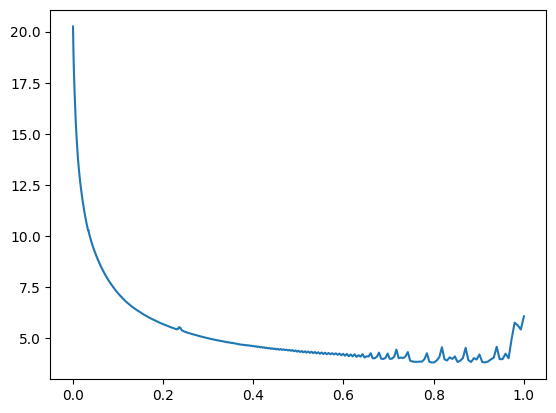

In [263]:
plt.plot(lri, lossi)

From this figure we understand the best learning rate is 0.1

The model seems to be prefect, ha? 

But this is not the case, since the more steps you train your model the better your model will be and this is because that your model is overfitting!

So we must split our data into 3 splits: train, dev/validation, and test.

We must track the model performance on the dev dataset.

In [5]:
# train, dev/validation, and test datasets(80, 10, 10)
def build_dataset(words):
    X, Y = [], []
    context = [0] * context_size
    for w in words:
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(41)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xts, Yts = build_dataset(words[n2:])

NameError: name 'words' is not defined

In [6]:
lr = 0.01
lossi = []
stepi = []

# train the model on the training set and then evaluate it on dev set and then compare the losses
for i in range(10000):

    # Forward Pass
    embed = E[Xtr].view(-1, context_size * n_embed)
    h = torch.tanh(embed @ W1 + b1)
    logits = h @ W2 + b2
    train_loss = F.cross_entropy(logits, Ytr)
    
    # Backward Pass
    for p in params:
        p.grad = None
    train_loss.backward()

    # Update Parameters
    for p in params:
        p.data += -lr * p.grad
    lossi.append(train_loss.log10().item())
    stepi.append(i)

embed = E[Xdev].view(-1, context_size * n_embed)
h = torch.tanh(embed @ W1 + b1)
logits = h @ W2 + b2
val_loss = F.cross_entropy(logits, Ydev)

print(f"Train Loss: {train_loss}\nValidation Loss: {val_loss}")

NameError: name 'E' is not defined

Instead of training on the whole dataset use mini batches of data

If you want to get a better result play with the hyperparameters:
1) embedding dimention
2) The number of neurons in the hidden layer
3) Learning rate
4) Size of the context window

# Part3: Activations and Gradients

In [7]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
# Build the vocabulary of characters and mappings to/from integers
words = open('names.txt').read().splitlines()
chars = sorted(list(set("".join(words))))
stoi = {ch: ix for ix, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ix: ch for ch, ix in stoi.items()}
vocab_size = len(stoi)

In [9]:
# Build the dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for ch in word + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

data_size = len(words)

n1 = int(0.8 * data_size)
n2 = int(0.9 * data_size)

# Split the data into train, dev and test
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xts, Yts = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
# MLP 
g = torch.Generator().manual_seed(2147483647)

n_embed = 10 # the dimentioanlity of the character embeddings
n_hidden = 200 # the number of neurons in the hiddent layer of MLP

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn((vocab_size), generator=g)
params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

print("Number of parameters of this MLP: ", sum(p.nelement() for p in params))

Number of parameters of this MLP:  11897


In [6]:
max_steps = 200000
batch_size = 43
lossi = []

for i in range(max_steps):

    # mini-batch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward Pass
    emb = C[Xb]
    emb_cat = emb.view(-1, (block_size * n_embed))
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in params:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 26.1824
  10000/ 200000: 2.3375
  20000/ 200000: 2.3453
  30000/ 200000: 2.0889
  40000/ 200000: 2.0961
  50000/ 200000: 2.8463
  60000/ 200000: 2.0973
  70000/ 200000: 2.3009
  80000/ 200000: 1.8813
  90000/ 200000: 2.2807
 100000/ 200000: 2.2915
 110000/ 200000: 1.9074
 120000/ 200000: 2.2711
 130000/ 200000: 1.7864
 140000/ 200000: 2.0935
 150000/ 200000: 2.0648
 160000/ 200000: 2.0030
 170000/ 200000: 2.1261
 180000/ 200000: 1.8882
 190000/ 200000: 2.0245


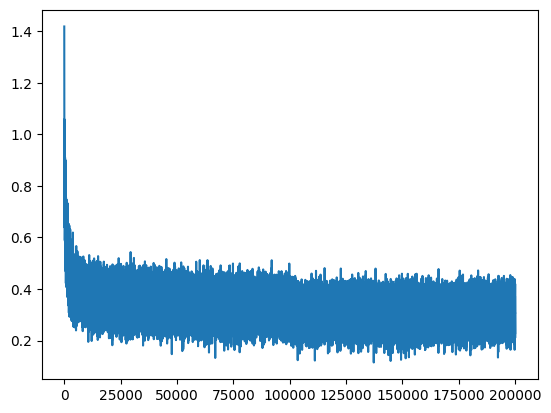

In [7]:
plt.plot(lossi) # in the first 10000 steps the neural net tries to squash down the weights

In [8]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev), 
        'tesy': (Xts, Yts)
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.066678285598755
dev 2.0984175205230713


In [9]:
# Sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break 
    print(''.join(itos[i] for i in out))   

desie.
yre.
.
ir.
lil.
nsiy.
mi.
d.
ildon.
l.
kylin.
m.
rie.
sid.
.
hrij.
.
s.
nish.
dineisely.


Our neural net is improperly initialized.

Look at the losses being printed during the training, in the beginning the loss is 27 and for the next iteration it becomes 2!

At first, we expect to have a uniformely probability distribution in our case we have 27 characters, so each character has 1/27.0 probability.


In [10]:
-torch.tensor(1/27.0).log() # This is the loss we expect to see in the beginning 

# 4-dimentional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # the gold label is index 2

print(probs, loss)


# Now let's change the logits
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() 

print(probs, loss)

# If you have extreme values in your logits, the loss will be higher(it can be -inf too!)
logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() 

print(probs, loss)

# So, in the initialization all the elements in the logits must be equal, ideally much closer to 0. So we set b2 to 0 and W2 near to 0 and not exactly 0


tensor([0.2500, 0.2500, 0.2500, 0.2500]) tensor(1.3863)
tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]) tensor(5.0553)
tensor([0.9882, 0.0118, 0.0000, 0.0000]) tensor(inf)


In [11]:
# MLP 
g = torch.Generator().manual_seed(2147483647)

n_embed = 10 # the dimentioanlity of the character embeddings
n_hidden = 200 # the number of neurons in the hiddent layer of MLP

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0
params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

print("Number of parameters of this MLP: ", sum(p.nelement() for p in params))

Number of parameters of this MLP:  11897


In [12]:
max_steps = 200000
batch_size = 43
lossi = []

for i in range(max_steps):

    # mini-batch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward Pass
    emb = C[Xb]
    emb_cat = emb.view(-1, (block_size * n_embed))
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in params:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2982
  10000/ 200000: 1.9245
  20000/ 200000: 2.0724
  30000/ 200000: 1.9949
  40000/ 200000: 1.8941
  50000/ 200000: 2.5519
  60000/ 200000: 1.9757
  70000/ 200000: 2.3264
  80000/ 200000: 1.8045
  90000/ 200000: 2.2164
 100000/ 200000: 2.1494
 110000/ 200000: 1.8365
 120000/ 200000: 2.0081
 130000/ 200000: 1.7663
 140000/ 200000: 2.0743
 150000/ 200000: 2.0977
 160000/ 200000: 1.8655
 170000/ 200000: 2.0644
 180000/ 200000: 1.8192
 190000/ 200000: 2.0432


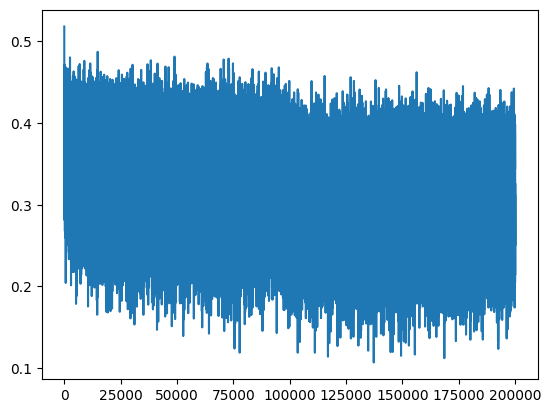

In [13]:
plt.plot(lossi) 
# When we compare this plot with the previous one, we observe that we don't have the hockey stick for the loss!

In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev), 
        'tesy': (Xts, Yts)
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

# We get better loss in comparison to the previous neural net.

train 2.015488624572754
dev 2.0723390579223633


The second problem is related to h. Where we have -1 and 1 values in this tensor.

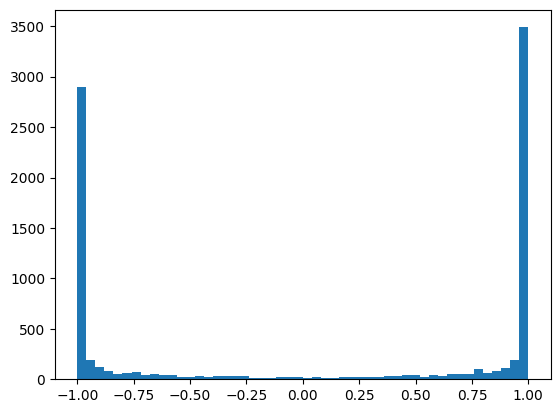

In [15]:
plt.hist(h.view(-1).tolist(), 50);

# We observe that most values take on -1 or 1. This indicates that this tanh is very very active.

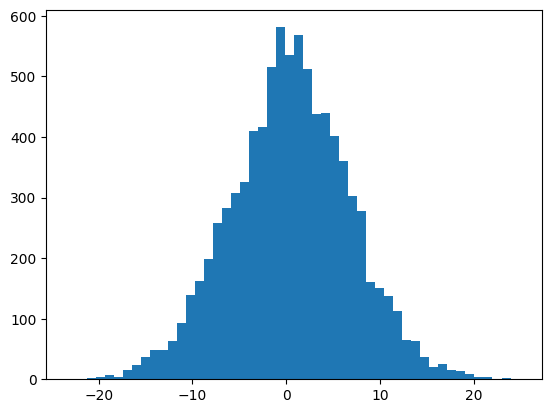

In [16]:
# The distribution of the pre activations are very broad.
plt.hist(hpreact.view(-1).tolist(), 50);

Let's look at what would happen to tanh function in the backward pass.

The derivative of the tanh(x) is 1 - tanh^2(x)

So, what would happen when the value of tanh is close to edge cases (-1 and 1) ?
the 1 -  tanh^2(x) will be 0 and it is blocking the back propagation

So whatever you change the weights and biases, it will not affect the loss.

This is where ```Gradient Vanishing``` problem occur.

What happen when the input is 0? in this case the derivative would be equal to gradient value and tanh become sort of inactive, and gradient just passes through it.


So, in our case where we have -1 and 1 among values of hpreact, the gradients that are passing through the network get destroyed.

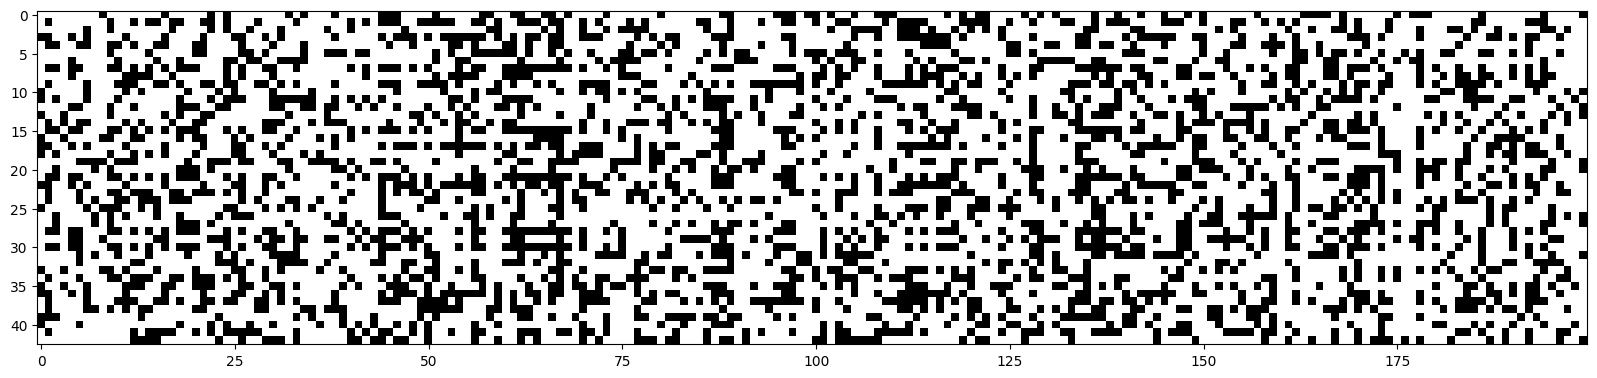

In [17]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') 
# This is a boolean tensor when you get White when it is True and vice versa.
# Most of the colors are white so the backward gradient will get destroyed.
# Dead Neuron? where we have all white values in a column
# This could happens when the initilization of the weights and biases are such that no single example could ever activate this tanh.
# If all the examples land in the tail of the tanh function, then this neuron will never learn!!!

Activation Functions that can be used which are not suffering from the Dead Neuron problem:

- Leaky ReLU
- ELU

You can either multiply the b1 by 0 or 0.01

When it is not 0, you will have more entropy in your initilization values which sometimes is efficient in optimization.

In [12]:
# MLP 
g = torch.Generator().manual_seed(2147483647)

n_embed = 10 # the dimentioanlity of the character embeddings
n_hidden = 200 # the number of neurons in the hiddent layer of MLP

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((n_embed*block_size, n_hidden), generator=g) * 0.01
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0
params = [C, W1, b1, W2, b2]

for p in params:
    p.requires_grad = True

print("Number of parameters of this MLP: ", sum(p.nelement() for p in params))

Number of parameters of this MLP:  11897


In [13]:
max_steps = 200000
batch_size = 43
lossi = []

for i in range(max_steps):

    # mini-batch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward Pass
    emb = C[Xb]
    emb_cat = emb.view(-1, (block_size * n_embed))
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in params:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2947
  10000/ 200000: 1.8658
  20000/ 200000: 2.1936
  30000/ 200000: 1.8829
  40000/ 200000: 2.0543
  50000/ 200000: 2.6621
  60000/ 200000: 2.0558
  70000/ 200000: 2.2590
  80000/ 200000: 1.8989
  90000/ 200000: 2.1199
 100000/ 200000: 2.1018
 110000/ 200000: 1.8507
 120000/ 200000: 1.9978
 130000/ 200000: 1.8540
 140000/ 200000: 2.1161
 150000/ 200000: 2.1063
 160000/ 200000: 1.9087
 170000/ 200000: 2.1120
 180000/ 200000: 1.9366
 190000/ 200000: 1.9915


In [14]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev), 
        'tesy': (Xts, Yts)
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.0347886085510254
dev 2.067748546600342


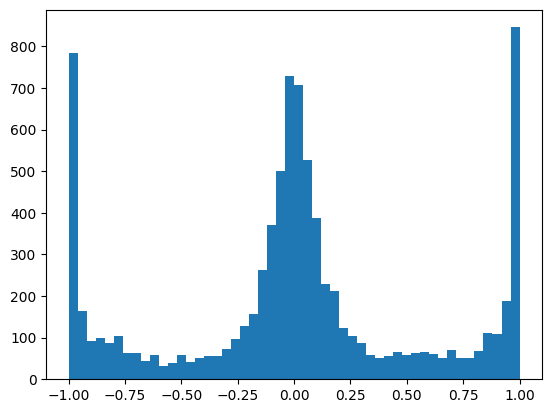

In [21]:
plt.hist(h.view(-1).tolist(), 50);

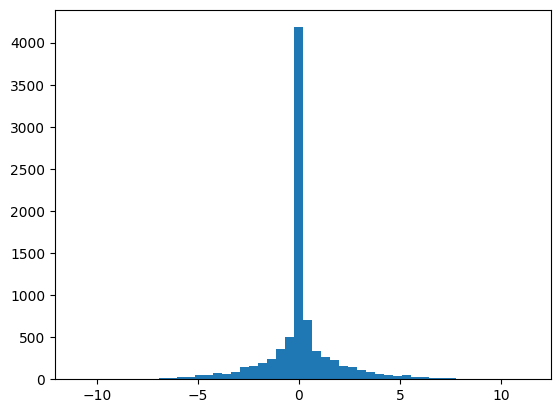

In [22]:
plt.hist(hpreact.view(-1).tolist(), 50);

We expect to have much lesser white values

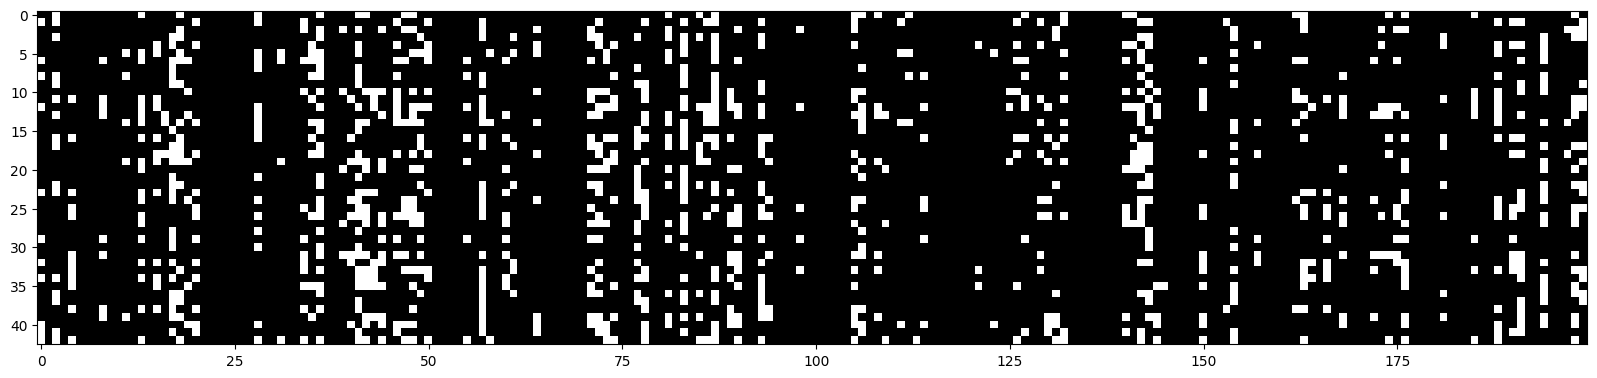

In [23]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') 

How did we know the 0.01 or 0.1 values that multiplied by the weights and biases? 

Should we set them manually like this? Surely not.

Normalize them by the square root of ```fan_in```

https://pytorch.org/docs/stable/nn.init.html

tensor(0.0132) tensor(0.9881)
tensor(0.0087) tensor(3.1752)


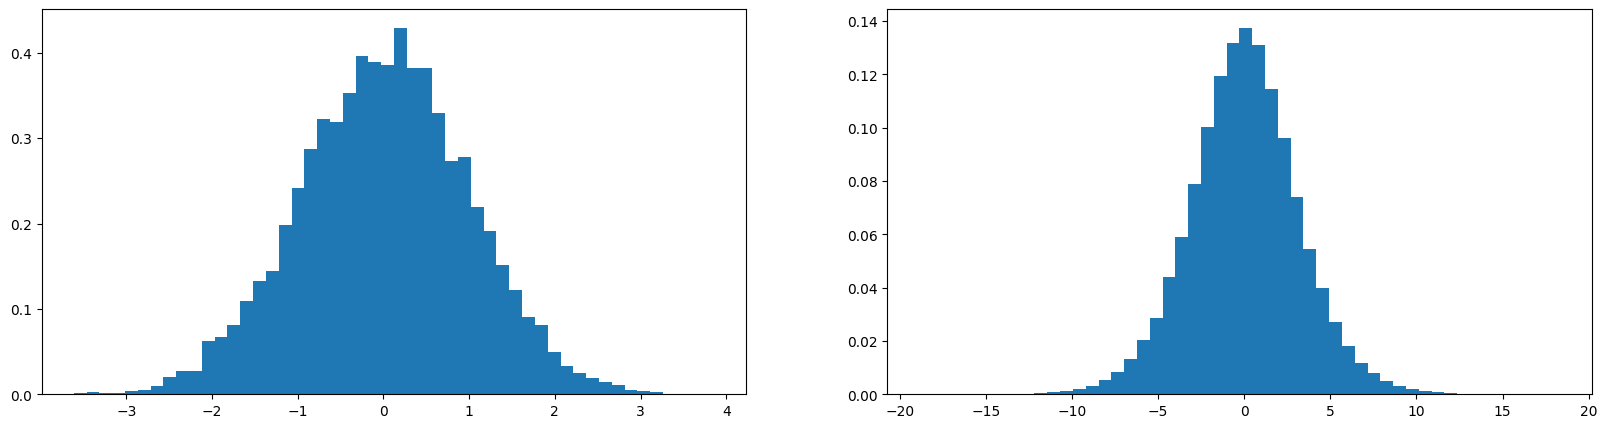

In [24]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


# Here, we observe that y has the same mean as x, but its std is different. What we want is to have the uniform gaussian dist.
# we need to multiply the w with a value so that the std be exactly 1?
# This scale value is the square root of the number of inputs, in our case it is 10, so we have 10 ** 0.5

tensor(-0.0094) tensor(0.9941)
tensor(-0.0014) tensor(0.9884)


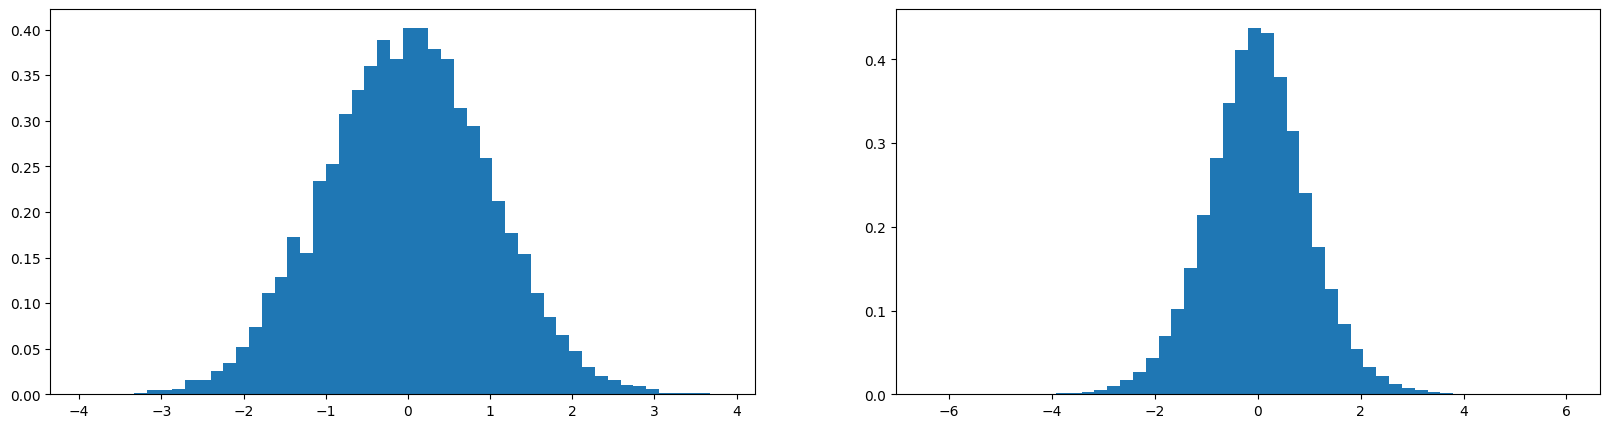

In [25]:
# Compare How the std becomes near 1 now

x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

What should be done in practice? Normalize the weights by the square root of the fan_in(number of inputs) known as Xavier Initialization.

Gain for tanh is 5 / 3, and the formula is:

gain / sqrt(fan_in)


But with novel techniques; like batch normalization, we don't need to do this.

if the value for the hpreact is too large, the tanh will be saturated and the gradients won't flow through it and if the values is too small, the tanh will be inactive. So what we want to have is a Gaussian distribution(mean 0 and std 1) for the hpreact.

In [ ]:
W1 = torch.randn(n_embed * block_size, n_hidden) * ((5 / 3) / (n_embed * block_size) ** 0.5)

In [22]:
mean = hpreact.mean(dim=0, keepdim=True)

In [23]:
std = hpreact.std(dim=0, keepdim=True)

In [ ]:
# one important point is that we want them to be Gaussian onlya t initilization,
# we don't want to normalize the values during the training
# We want the distribution to move around the Gaussian distribution, 
hpreact = (hpreact - mean) / std


In [29]:
# So, in addition to the activation normalization, we need to implement the scale and shift.
# These two will be learned parameters.
batch_normalization_gain = torch.ones((1, n_hidden))
batch_normalization_bias = torch.zeros((1, n_hidden))

hpreact = hpreact * batch_normalization_gain + batch_normalization_bias

In [42]:
# MLP 
g = torch.Generator().manual_seed(2147483647)

n_embed = 10 # the dimentioanlity of the character embeddings
n_hidden = 200 # the number of neurons in the hiddent layer of MLP

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn(n_embed * block_size, n_hidden) * ((5 / 3) / (n_embed * block_size) ** 0.5)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0
params = [C, W1, b1, W2, b2, batch_normalization_gain, batch_normalization_bias]

for p in params:
    p.requires_grad = True

print("Number of parameters of this MLP: ", sum(p.nelement() for p in params))

Number of parameters of this MLP:  12297


In [43]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # mini-batch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward Pass
    emb = C[Xb]
    emb_cat = emb.view(-1, (block_size * n_embed))
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation
    hpreact = ((hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)) * batch_normalization_gain + batch_normalization_bias
    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in params:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2874
  10000/ 200000: 2.3011
  20000/ 200000: 1.8048
  30000/ 200000: 2.1149
  40000/ 200000: 2.4343
  50000/ 200000: 1.8398
  60000/ 200000: 2.2906
  70000/ 200000: 2.2278
  80000/ 200000: 1.8836
  90000/ 200000: 2.3580
 100000/ 200000: 1.7061
 110000/ 200000: 2.0210
 120000/ 200000: 1.7906
 130000/ 200000: 1.7149
 140000/ 200000: 2.2116
 150000/ 200000: 2.2208
 160000/ 200000: 2.1261
 170000/ 200000: 2.0905
 180000/ 200000: 1.9752
 190000/ 200000: 2.0594


In [44]:
# Calibrate the batch norm at the end of the training

with torch.no_grad():
    emb = C[Xtr]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    # measure the mean and std over the entire training set
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

In [45]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev), 
        'tesy': (Xts, Yts)
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = batch_normalization_gain * ((hpreact - bnmean) / bnstd) + batch_normalization_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.033318042755127
dev 2.062140941619873


Since we are lazy, we don't want to calculate this mean and std after trianing, we are in favor of doing it during the training.

In [65]:
# MLP 
g = torch.Generator().manual_seed(2147483647)

n_embed = 10 # the dimentioanlity of the character embeddings
n_hidden = 200 # the number of neurons in the hiddent layer of MLP

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn(n_embed * block_size, n_hidden) * ((5 / 3) / (n_embed * block_size) ** 0.5)
b1 = torch.randn((n_hidden), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0
params = [C, W1, b1, W2, b2, batch_normalization_gain, batch_normalization_bias]

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

for p in params:
    p.requires_grad = True

print("Number of parameters of this MLP: ", sum(p.nelement() for p in params))

Number of parameters of this MLP:  12297


Why do we want to learn the beta and gamma?

if we don't learn them, with batch normalization, it will enforce all the features to have 0 mean and 1 std which limits the expressivness of the network.

In [70]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # mini-batch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward Pass
    emb = C[Xb]
    emb_cat = emb.view(-1, (block_size * n_embed))
    hpreact = emb_cat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = ((hpreact - bnmeani) / bnstdi) * batch_normalization_gain + batch_normalization_bias

    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001

    h = torch.tanh(hpreact) # hidden layer 
    logits = h @ W2 + b2 # output layer 
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass
    for p in params:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in params:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 2.1689
  10000/ 200000: 2.0522
  20000/ 200000: 1.9543
  30000/ 200000: 2.1376
  40000/ 200000: 1.8380
  50000/ 200000: 2.1113
  60000/ 200000: 2.4412
  70000/ 200000: 1.9791
  80000/ 200000: 1.7699
  90000/ 200000: 1.5959
 100000/ 200000: 2.2258
 110000/ 200000: 1.6874
 120000/ 200000: 1.7105
 130000/ 200000: 2.2194
 140000/ 200000: 2.1475
 150000/ 200000: 2.0804
 160000/ 200000: 1.9540
 170000/ 200000: 2.2437
 180000/ 200000: 2.1880
 190000/ 200000: 2.1932


In [75]:
# Calibrate the batch norm at the end of the training
# This is the explcit estimation, and we expect that bnmean_running be close to bnmean

with torch.no_grad():
    emb = C[Xtr]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    # measure the mean and std over the entire training set
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)

In [76]:
bnmean

tensor([[-1.2997e+00,  5.0733e-01, -1.3825e+00,  1.4485e+00, -1.2276e+00,
          2.8199e+00,  4.1306e-01,  8.5502e-01, -7.0712e-01, -2.2314e+00,
          3.8998e-03, -9.8658e-01, -3.1091e-01, -1.7155e+00, -3.6031e+00,
          4.1454e-01, -2.2387e+00, -2.3842e-01,  5.5498e-01,  1.7090e+00,
         -8.4794e-01, -2.4387e+00,  1.4109e+00,  4.0837e-01,  1.1275e+00,
          1.4594e+00,  9.5530e-01,  6.4810e-01, -1.3619e+00,  5.2987e-01,
          1.2451e+00,  6.9148e-01, -5.8153e-01,  1.0868e-01, -1.0362e+00,
          1.0367e-01, -3.2972e+00, -2.0555e+00, -4.3397e-01, -1.1479e+00,
         -3.4623e-01,  7.5132e-01, -7.4391e-01,  4.2132e-01, -2.1034e+00,
          2.0323e+00,  2.0692e+00, -1.6811e+00,  1.3877e+00,  3.8762e+00,
         -4.2263e-02, -7.3660e-01, -1.9067e-01, -9.5858e-01,  2.2423e+00,
          1.3121e+00,  2.1371e+00,  8.7368e-01,  7.9221e-01,  2.9025e+00,
          3.0203e+00, -4.2447e-01,  4.6661e-02,  1.4912e+00,  3.8741e-01,
          1.5920e+00,  6.0802e-01, -3.

In [77]:
bnmean_running

tensor([[-1.3059e+00,  4.8469e-01, -1.3825e+00,  1.4462e+00, -1.2102e+00,
          2.8272e+00,  4.2386e-01,  8.4195e-01, -7.2516e-01, -2.2574e+00,
          2.4532e-02, -9.6833e-01, -3.0643e-01, -1.7388e+00, -3.5954e+00,
          3.9900e-01, -2.2739e+00, -2.3845e-01,  5.8109e-01,  1.6917e+00,
         -8.5687e-01, -2.4279e+00,  1.4247e+00,  4.0440e-01,  1.1332e+00,
          1.4647e+00,  9.5703e-01,  6.5030e-01, -1.3821e+00,  5.3544e-01,
          1.2609e+00,  6.7324e-01, -5.9667e-01,  1.1391e-01, -1.0559e+00,
          1.2274e-01, -3.2905e+00, -2.0594e+00, -4.1614e-01, -1.1466e+00,
         -3.3904e-01,  7.6331e-01, -7.5148e-01,  4.3005e-01, -2.1038e+00,
          2.0393e+00,  2.0734e+00, -1.6867e+00,  1.3732e+00,  3.8666e+00,
         -4.8445e-02, -7.3522e-01, -1.7284e-01, -9.5903e-01,  2.2299e+00,
          1.3148e+00,  2.1326e+00,  8.7674e-01,  7.6484e-01,  2.9084e+00,
          3.0293e+00, -4.2135e-01,  6.3374e-02,  1.4916e+00,  3.9692e-01,
          1.6065e+00,  5.8797e-01, -3.

Since they are identical we don't need to run the below code for calibration

```
with torch.no_grad():
    emb = C[Xtr]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    # measure the mean and std over the entire training set
    bnmean = hpreact.mean(dim=0, keepdim=True)
    bnstd = hpreact.std(dim=0, keepdim=True)
```

In [ ]:
# instead of bmean, we can use bmean_running
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev), 
        'tesy': (Xts, Yts)
    }[split]

    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    hpreact = batch_normalization_gain * ((hpreact - bnmean_running) / bnstd_running) + batch_normalization_bias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 2.022183656692505
dev 2.0624704360961914


One important point is that b1 is never be taken into account when calculating the hpreact, so whenever we use batch normalization, we skip b1. Instead, we have bnbias which is in charge of shifting the distribution.


#### Batch Normalization

Basically when your linear layer is followed by a batch normalization layer, defining bias for that layer is useless!

In [159]:
g = torch.Generator().manual_seed(SEED)

n_embed = 10
n_hidden = 200
fan_in = n_embed * block_size
scaling_factor = (5/3) * (fan_in) ** -0.5

C = torch.randn((vocab_size, n_embed), generator=g)
W1 = torch.randn((fan_in, n_hidden), generator=g) * scaling_factor
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# Batch Norm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

params = [C, W1, W2, b2, bngain, bnbias]

for p in params:
    p.requires_grad = True

print("Number of parameters of this MLP: ", sum(p.nelement() for p in params))

Number of parameters of this MLP:  12097


In [94]:
batch_size = 32
max_steps = 200000
lossi = []

for i in range(max_steps):
    # mini-batch construct
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    embed = C[Xb]
    embed = embed.view(-1, (block_size * n_embed))
    # Linear layer
    hpreact = embed @ W1
    # Batch Norm Layer
    bnmeani = hpreact.mean(dim=0, keepdim=True)
    bnstdi = hpreact.std(dim=0, keepdim=True)
    hpreact = ((hpreact - bnmeani) / bnstdi) * bngain + bnbias 

    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
    
    # Non-Linearity
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in params: 
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in params:
        p.data += -lr * p.grad
    
    # Track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.2887
  10000/ 200000: 1.9119
  20000/ 200000: 2.6331
  30000/ 200000: 2.1181
  40000/ 200000: 2.3083
  50000/ 200000: 1.6683
  60000/ 200000: 1.8601
  70000/ 200000: 2.2645
  80000/ 200000: 2.3744
  90000/ 200000: 2.0782
 100000/ 200000: 2.2783
 110000/ 200000: 2.1565
 120000/ 200000: 1.5972
 130000/ 200000: 1.9648
 140000/ 200000: 2.1930
 150000/ 200000: 1.9912
 160000/ 200000: 2.0238
 170000/ 200000: 2.2463
 180000/ 200000: 1.9953
 190000/ 200000: 1.9591


As you make your network bigger, larger, and deeper, we don't want to have hockey stick plot for our output loss, and also we need to control the activation since we don't want sqush to 0 or explode to infinity.
We are in favor of having Guassian distribution throughout the nural networks.
Types of normailization used in practice:

Batch, Group, Layer, Instance Normalization.
The idea of batch normalization is to centralize the data before passing it to the non-linearity. We add gain and bias as learnable parameters. We did this during training, but the question is what should we do at inference time?


### Torchifying what we have done so far

In [177]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) #/ (fan_in ** 0.5)
        self.bias = torch.zeros((fan_out)) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    # in pytorc implementation using the gamma and beta is set with the affine argument.
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xstd = x.var(0, keepdim=True, unbiased=False)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1 - self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1- self.momentum) + xvar * self.momentum
        return self.out    

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

Batch1dNorm has a different behavior when you used it in training or inference, that's why we defined the training attribute in its class.

In [180]:
n_mebed = 10 # the dimentionality of the charatcter embedding vector
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(SEED)


C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers, apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


In [181]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward Pass
    embed = C[Xb] # embed the characters into vectors
    x = embed.view(embed.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # Backward Pass
    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    lr = 0.01 if i < 100000 else 0.001 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break

      0/ 200000: 4.0511


In this case, the last layer is not good it means that we are training the last layer 10 times faster than the other layers. But keep in mind that we trained our model for one epoch. If we train it for more epochs, the last layer will catch up.
What really matters is not the gradient to the data ratio, but the update to the data ratio.
Because that is the amount by which we actually change the data.

Analyzing activation statistics both in the forward and backward pass

Layer 1: mean: -0.02, std: 0.58, saturated: 20.88%
Layer 3: mean: -0.01, std: 0.47, saturated: 7.84%
Layer 5: mean: 0.02, std: 0.44, saturated: 6.47%
Layer 7: mean: -0.01, std: 0.42, saturated: 5.09%
Layer 9: mean: -0.01, std: 0.43, saturated: 5.88%


Text(0.5, 1.0, 'Activation Distribution')

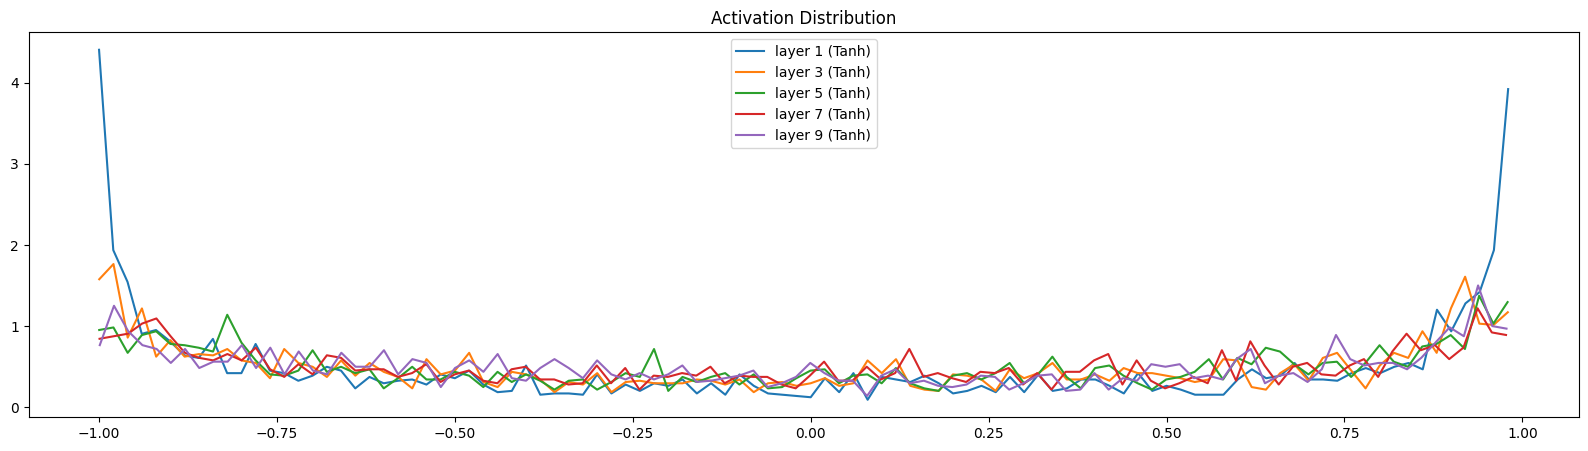

In [116]:
# Visualize histograms
plt.figure(figsize=(20, 5))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"Layer {i}: mean: {t.mean():.2f}, std: {t.var():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation Distribution")

The first layer is totally saturated, but everything except this one is stable.
The reason that it is stable is because of the gain(5/3 for Tanh) 

#### What would happern if we set the gain to 1?

the standard deviation starts to shrinking and saturation becomes 0.

Layer 1: mean: -0.02, std: 0.40, saturated: 3.41%
Layer 3: mean: -0.01, std: 0.23, saturated: 0.03%
Layer 5: mean: 0.01, std: 0.16, saturated: 0.00%
Layer 7: mean: 0.00, std: 0.12, saturated: 0.00%
Layer 9: mean: -0.00, std: 0.10, saturated: 0.00%


Text(0.5, 1.0, 'Activation Distribution')

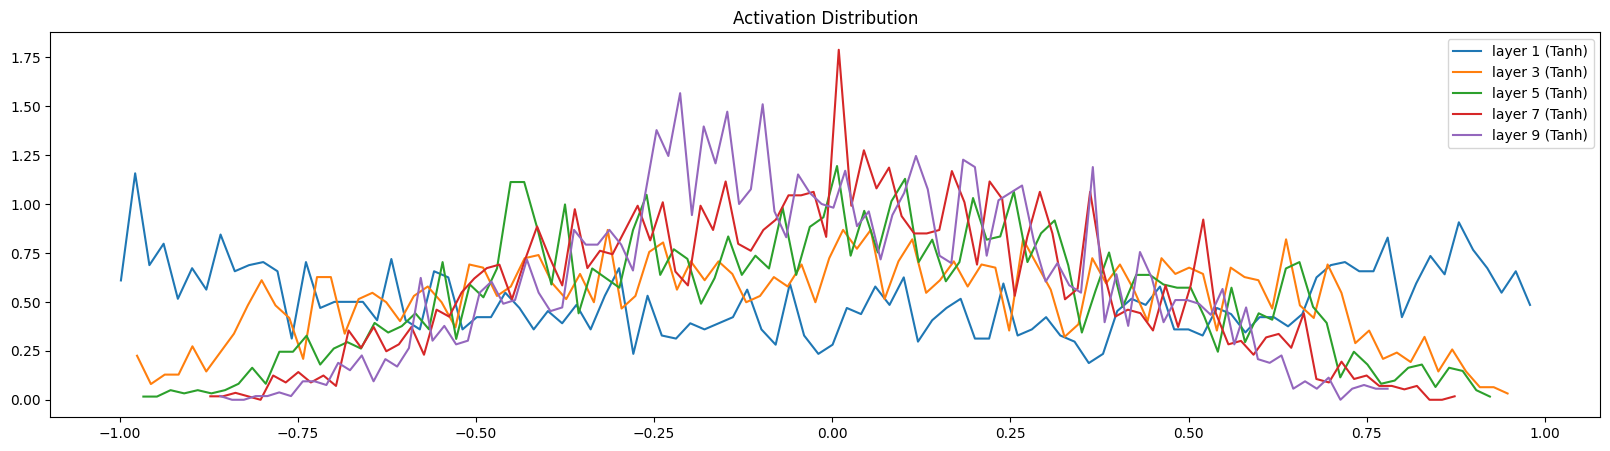

In [119]:
# The first layer is pretty descent, but then all the other layers shrink down to 0(things will come toward zero).
# When we have a sandwitch of linear layers alone, and since Tanh is a squashing function, it takes the distribution and squash it. So some gain is necessary to keep expanding it.
# Without the gain, the network tends to collapse into a more linear behavior, reducing its ability to learn complex patterns.

Layer 1: mean: -0.02, std: 0.74, saturated: 49.25%
Layer 3: mean: -0.00, std: 0.70, saturated: 40.81%
Layer 5: mean: 0.02, std: 0.70, saturated: 40.91%
Layer 7: mean: -0.01, std: 0.70, saturated: 40.75%
Layer 9: mean: -0.00, std: 0.70, saturated: 41.22%


Text(0.5, 1.0, 'Activation Distribution')

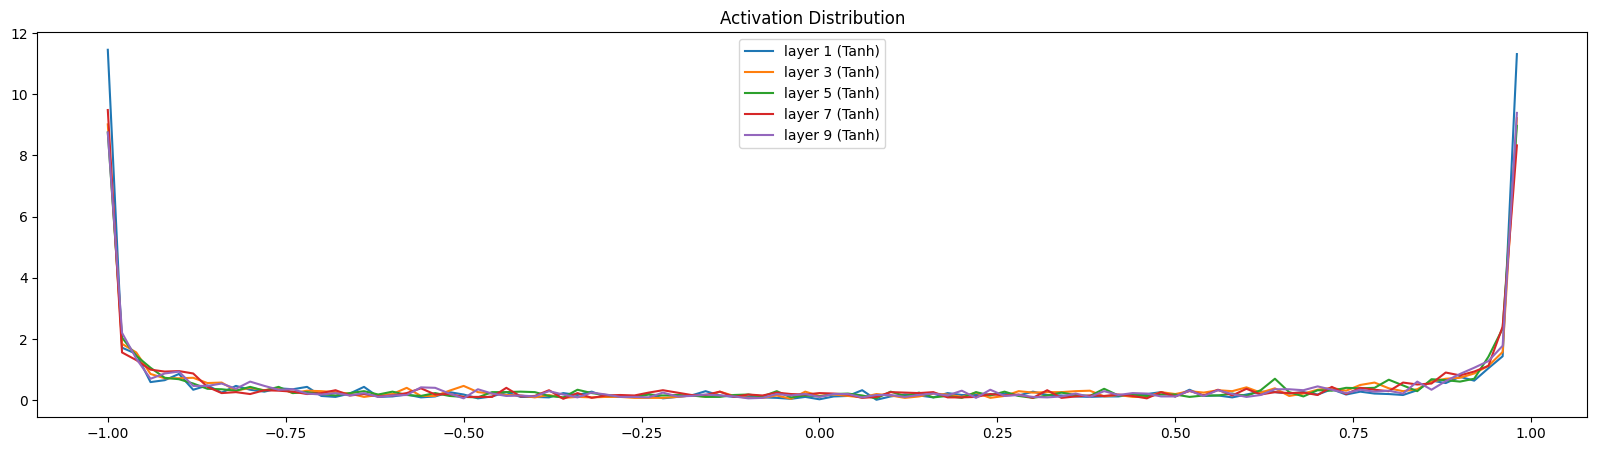

In [122]:
# Now Let's set the gain to a bigger value like 3:
# We see that the saturations become too large.

Layer 1 (Tanh): mean: 1.898933624033816e-05, std: 2.1325899979274254e-07
Layer 3 (Tanh): mean: 1.3535463949665427e-05, std: 1.9247367788466363e-07
Layer 5 (Tanh): mean: 3.4099016374966595e-06, std: 1.6425968851763173e-07
Layer 7 (Tanh): mean: 1.5671126675442792e-05, std: 1.243651297500037e-07
Layer 9 (Tanh): mean: 6.206617854331853e-06, std: 9.92896502793883e-08


Text(0.5, 1.0, 'Gradient Distribution')

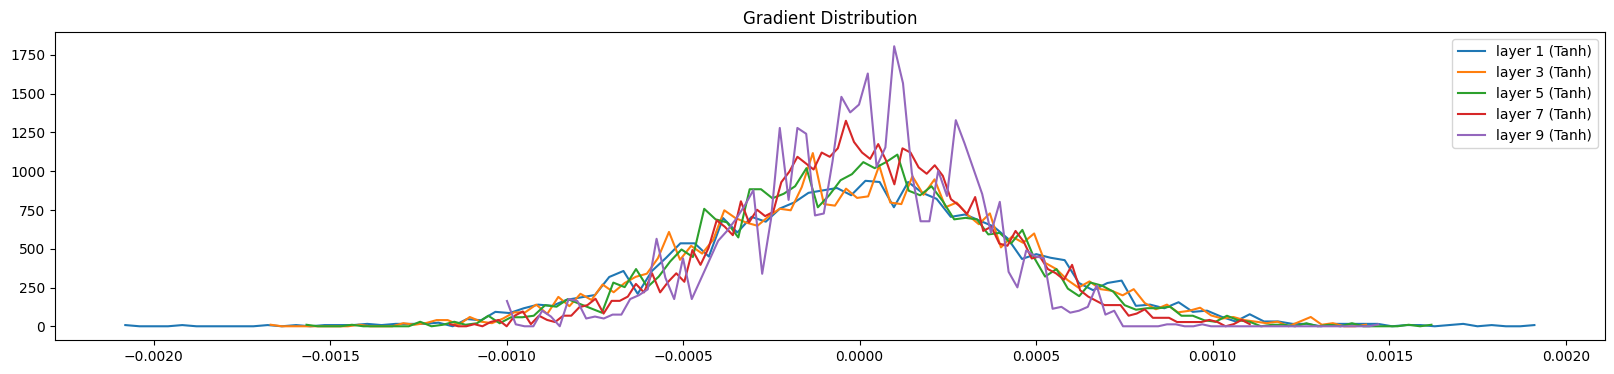

In [129]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"Layer {i} ({layer.__class__.__name__}): mean: {t.mean()}, std: {t.var()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient Distribution")

This figure shows that all of the layers have the same distribution, and none of them is shrinking or expanding.

Layer 1 (Tanh): mean: 7.641298793714668e-07, std: 4.4111014840808593e-10
Layer 3 (Tanh): mean: 2.040364961430896e-06, std: 1.8705430537835355e-09
Layer 5 (Tanh): mean: 2.4503967779310187e-06, std: 7.55480034086986e-09
Layer 7 (Tanh): mean: 9.627353392716032e-06, std: 2.7046898054550184e-08
Layer 9 (Tanh): mean: 6.264102466957411e-06, std: 9.9091145955299e-08


Text(0.5, 1.0, 'Gradient Distribution')

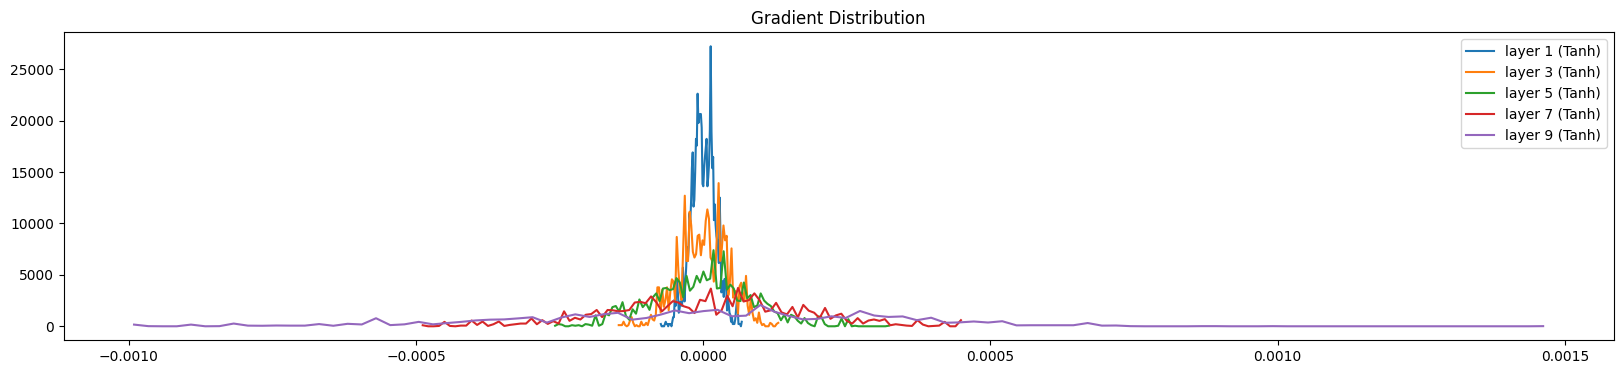

In [132]:
# Set the gain to 0.5:
# The gradients are expanding out when we move toward the layers.

Why the layers near input have wider distribution while the layers near output have narrower distribution?
```
# Forward pass with gain = 0.5
W = torch.randn((fan_in, fan_out)) * 0.5  # Small weights

# Forward propagation
h1 = x @ W      # Multiplication makes activations smaller

# Backward propagation
grad_h1 = grad_out @ W.T    # Multiplication by transpose
```
The crucial point is:

In forward pass: we multiply by small weights, making activations smaller

In backward pass: we multiply by the transpose of these weights

If W is a tall matrix (fan_out > fan_in)
Then W.T is a wide matrix
This means each gradient gets combined with multiple paths
Even with small weights, summing many paths can lead to larger gradients

Example:
```
# If we have:
fan_in = 10
fan_out = 100
W = torch.randn(10, 100) * 0.5  # Small weights

# Forward: (batch_size, 10) @ (10, 100) -> outputs get smaller
# Backward: (batch_size, 100) @ (100, 10) -> gradients combine from many paths
```



Layer 1 (Tanh): mean: -2.4232583655248163e-06, std: 1.2566731584229274e-06
Layer 3 (Tanh): mean: 1.3483485417964403e-05, std: 6.340297886708868e-07
Layer 5 (Tanh): mean: -6.001012025080854e-07, std: 3.3381809316779254e-07
Layer 7 (Tanh): mean: 6.530799510073848e-06, std: 1.747276598962344e-07
Layer 9 (Tanh): mean: 6.0863676480948925e-06, std: 9.944215406676449e-08


Text(0.5, 1.0, 'Gradient Distribution')

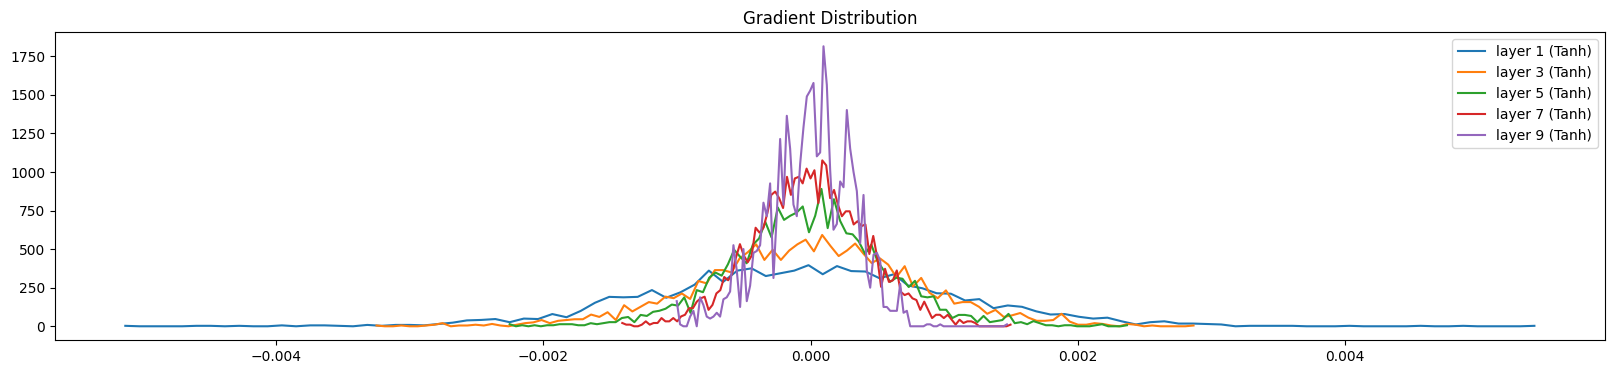

In [135]:
# When we set the gain to a large value (3 in this case)

### What would happen if we remove the Tanh layers, but keep the gain as 5/3?

Layer 0: mean: -0.04, std: 2.79, saturated: 56.88%
Layer 1: mean: -0.12, std: 7.28, saturated: 71.50%
Layer 2: mean: 0.08, std: 20.00, saturated: 80.97%
Layer 3: mean: 0.09, std: 53.98, saturated: 91.00%
Layer 4: mean: -0.31, std: 152.60, saturated: 93.88%


Text(0.5, 1.0, 'Activation Distribution')

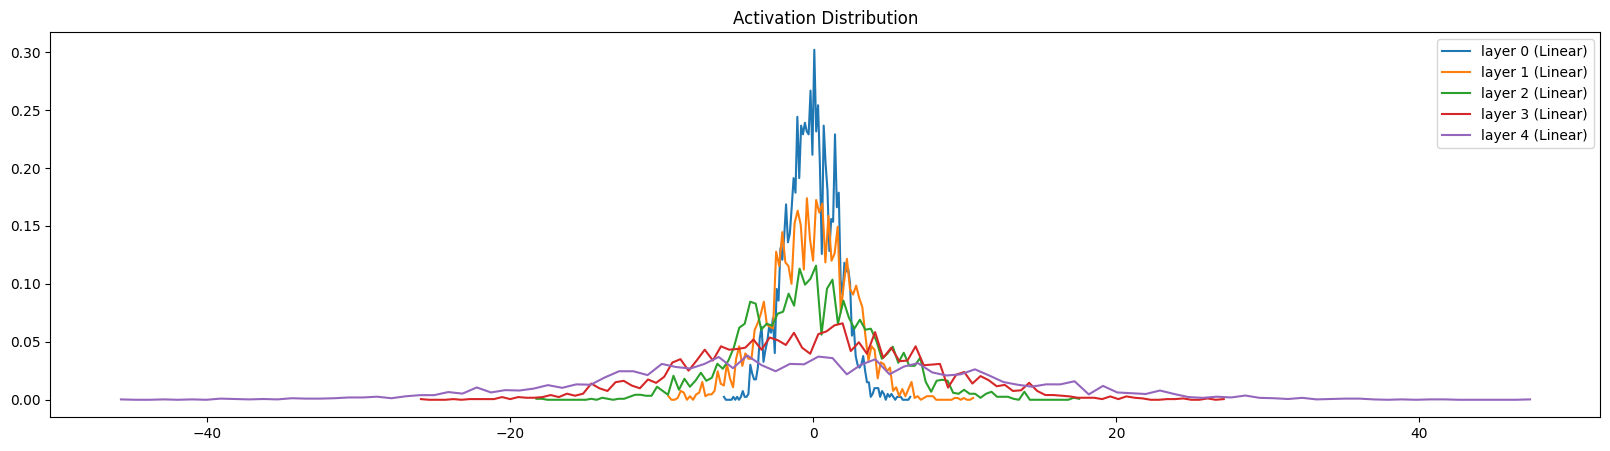

In [145]:
# Visualize histograms
plt.figure(figsize=(20, 5))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Linear):
        t = layer.out
        print(f"Layer {i}: mean: {t.mean():.2f}, std: {t.var():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Activation Distribution")

It starts to become diffused from layer 0 toward layer 4.

Layer 0 (Linear): mean: 8.467286534141749e-05, std: 8.312134923471604e-06
Layer 1 (Linear): mean: 7.762911263853312e-05, std: 2.9615307539643254e-06
Layer 2 (Linear): mean: 3.2734718843130395e-05, std: 1.0474436749063898e-06
Layer 3 (Linear): mean: 2.493658394087106e-05, std: 3.30776288137713e-07
Layer 4 (Linear): mean: 6.1854393607063685e-06, std: 1.0846213882587108e-07
Layer 5 (Linear): mean: -8.62335723661456e-12, std: 3.823314909823239e-05


Text(0.5, 1.0, 'Gradient Distribution')

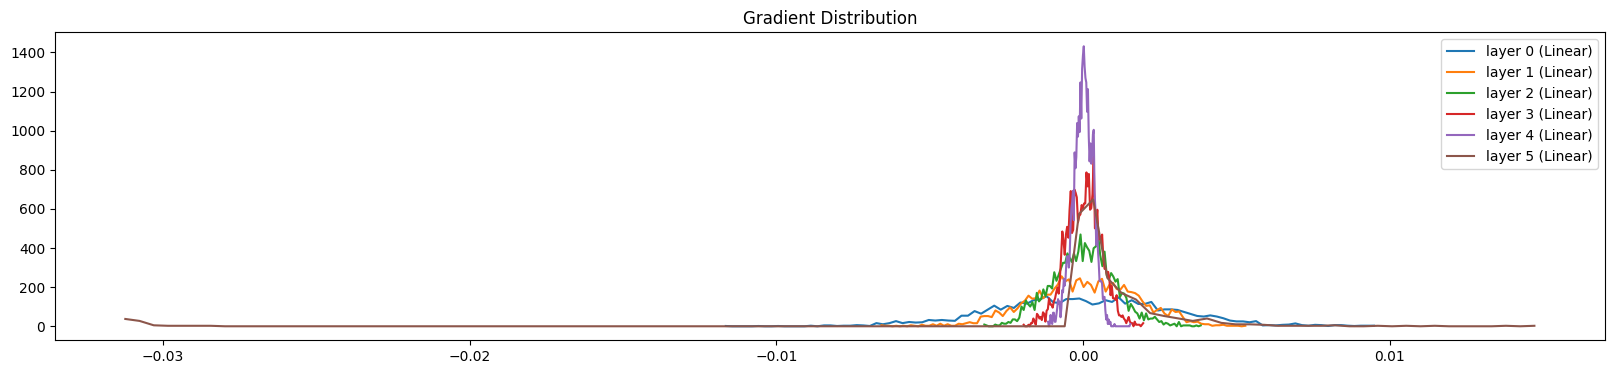

In [146]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers):
    if isinstance(layer, Linear):
        t = layer.out.grad
        print(f"Layer {i} ({layer.__class__.__name__}): mean: {t.mean()}, std: {t.var()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("Gradient Distribution")

The gradients diminish as we go down deep in the layers.

weight: (27, 10) | mean: -0.019191531464457512 | std: 1.0001055002212524 | grad:data ratio 0.008551477454602718
weight: (30, 100) | mean: 0.006625045090913773 | std: 0.31168800592422485 | grad:data ratio 0.020258309319615364
weight: (100, 100) | mean: -0.0009829860646277666 | std: 0.16605785489082336 | grad:data ratio 0.03308330848813057
weight: (100, 100) | mean: 0.0007981971721164882 | std: 0.16787110269069672 | grad:data ratio 0.025610534474253654
weight: (100, 100) | mean: 0.00354551849886775 | std: 0.16725574433803558 | grad:data ratio 0.0209311842918396
weight: (100, 100) | mean: -0.0006275899359025061 | std: 0.16757628321647644 | grad:data ratio 0.014059481211006641
weight: (100, 27) | mean: -1.4238534276955761e-05 | std: 0.03144225850701332 | grad:data ratio 0.6356223821640015


Text(0.5, 1.0, 'Weights Gradient Distribution')

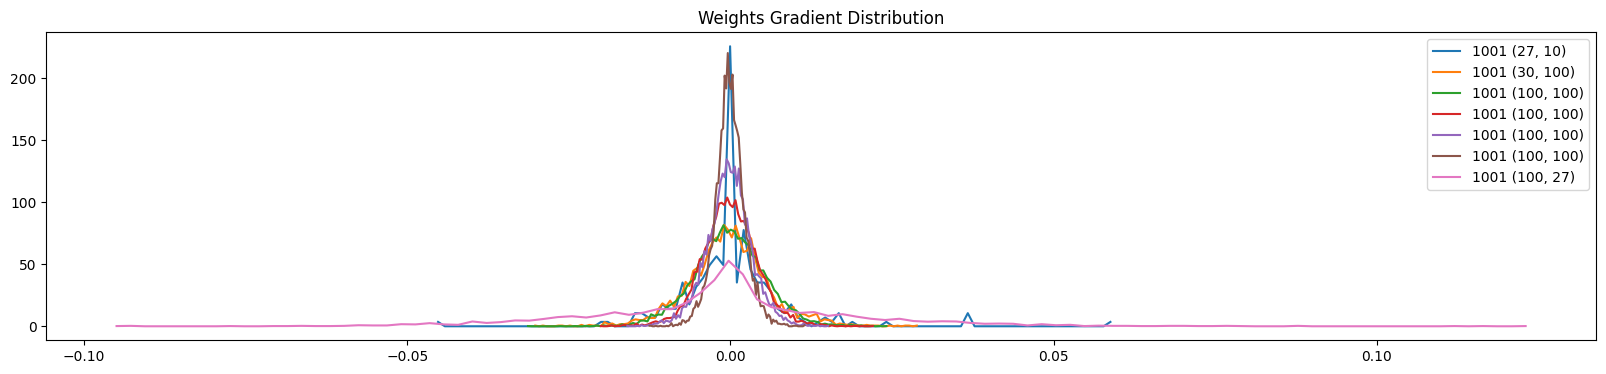

In [171]:
plt.figure(figsize=(20, 4))
legends = []
for p in parameters:
    t = p.grad
    if p.ndim == 2:
        # if grad to data is high, we are in trouble
        print(f"weight: {tuple(p.shape)} | mean: {p.mean()} | std: {p.std()} | grad:data ratio {t.std()/p.std()}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("Weights Gradient Distribution")

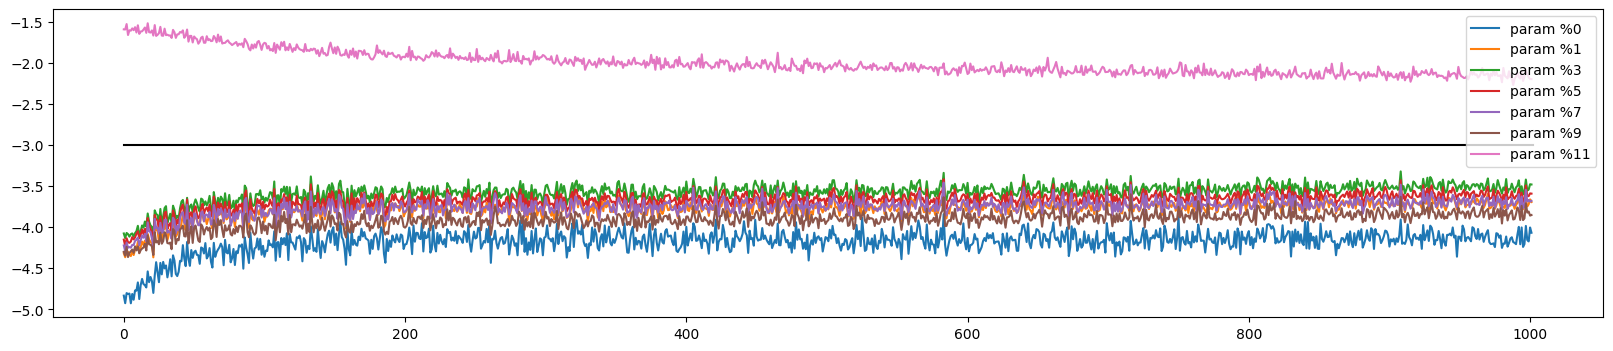

In [173]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f"param %{i}")
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

From this plot, we can see that during initilization they take on certain values but then they evolve to stabilize.
Why 1e-3?

The updates to the weights are no more than roughly 1e-3. if it was -1(the black line), it means they would undergo a lot of changes.

Why the final layer(pink one) is an outlier? because it was shrunk down to keep the softmax unconfident.

It is a good practice to check the update ratio of the parameters and make sure they are not more than 1e-3. If it is below -3, it mmeans the parametrs are not being trained fast enough. so the learning rate is low.

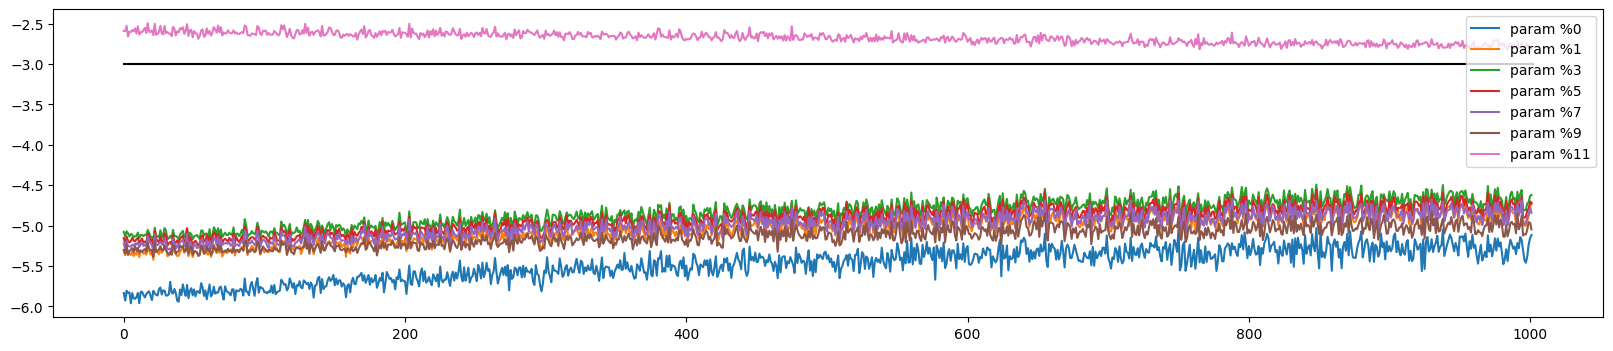

In [176]:
# Set lr to:
# lr = 0.001

# All of the updates are way toooo small.

Remove the fan_in ** 0.5 from the weight initialization:
Everything will be messed up.

Layer 1: mean: -0.03, std: 0.95, saturated: 88.72%
Layer 3: mean: -0.04, std: 0.95, saturated: 89.81%
Layer 5: mean: -0.01, std: 0.95, saturated: 89.31%
Layer 7: mean: 0.02, std: 0.96, saturated: 90.84%
Layer 9: mean: 0.01, std: 0.95, saturated: 89.94%


Text(0.5, 1.0, 'Activation Distribution')

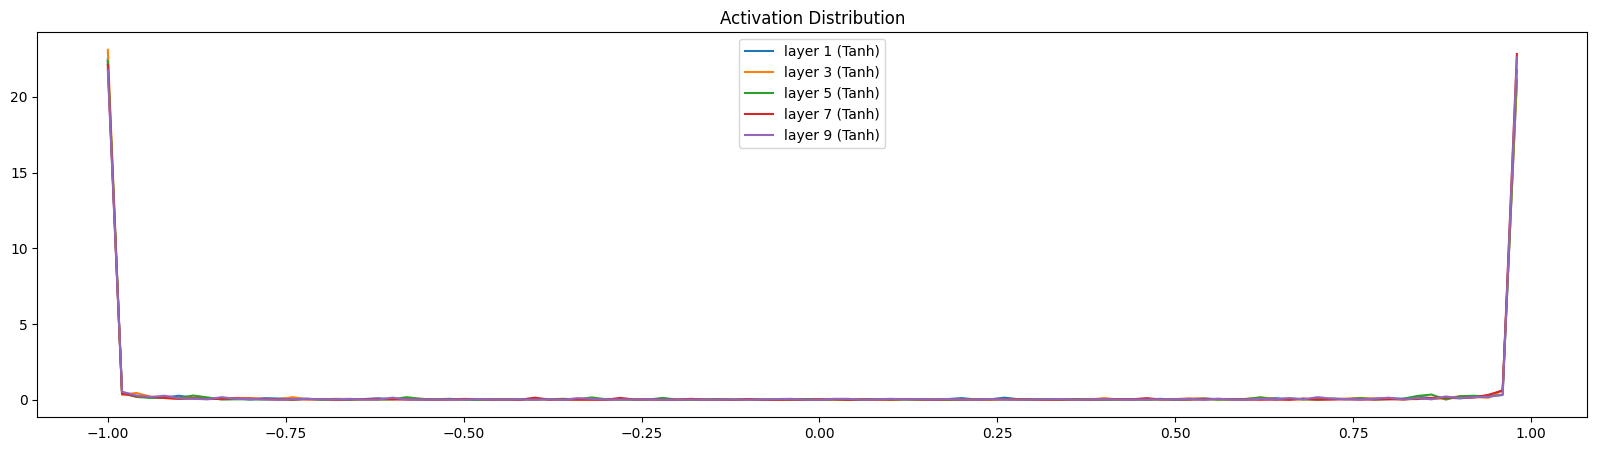

Layer 1 (Tanh): mean: -0.0010048646945506334, std: 0.02776878885924816
Layer 3 (Tanh): mean: 0.0002652702387422323, std: 0.004259232431650162
Layer 5 (Tanh): mean: -0.0001912071165861562, std: 0.00030444542062468827
Layer 7 (Tanh): mean: -6.49665598757565e-05, std: 4.6664161345688626e-05
Layer 9 (Tanh): mean: -1.0644318535923958e-05, std: 5.607313596556196e-06


Text(0.5, 1.0, 'Gradient Distribution')

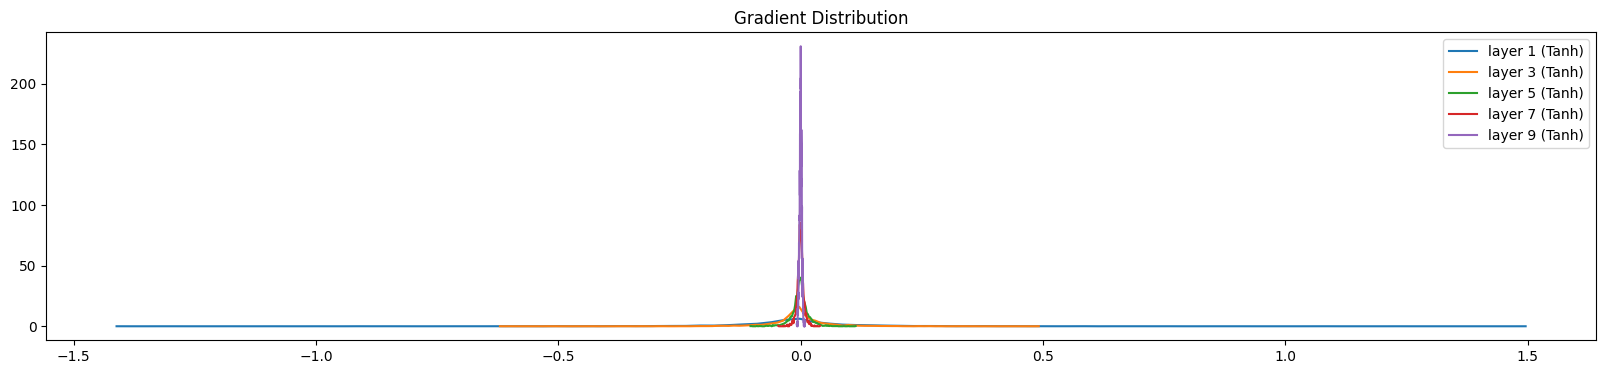

weight: (27, 10) | mean: -0.030020898208022118 | std: 1.1049662828445435 | grad:data ratio 0.8589833974838257
weight: (30, 100) | mean: 0.03875117003917694 | std: 1.7108088731765747 | grad:data ratio 0.13360817730426788
weight: (100, 100) | mean: -0.008926690556108952 | std: 1.6613675355911255 | grad:data ratio 0.037058208137750626
weight: (100, 100) | mean: 0.007197163999080658 | std: 1.6788520812988281 | grad:data ratio 0.014340867288410664
weight: (100, 100) | mean: 0.034766264259815216 | std: 1.6718133687973022 | grad:data ratio 0.0038893017917871475
weight: (100, 100) | mean: -0.0064082578755915165 | std: 1.6734272241592407 | grad:data ratio 0.0014609164791181684
weight: (100, 27) | mean: -0.00014238392759580165 | std: 0.08270077407360077 | grad:data ratio 0.3738582730293274


Text(0.5, 1.0, 'Weights Gradient Distribution')

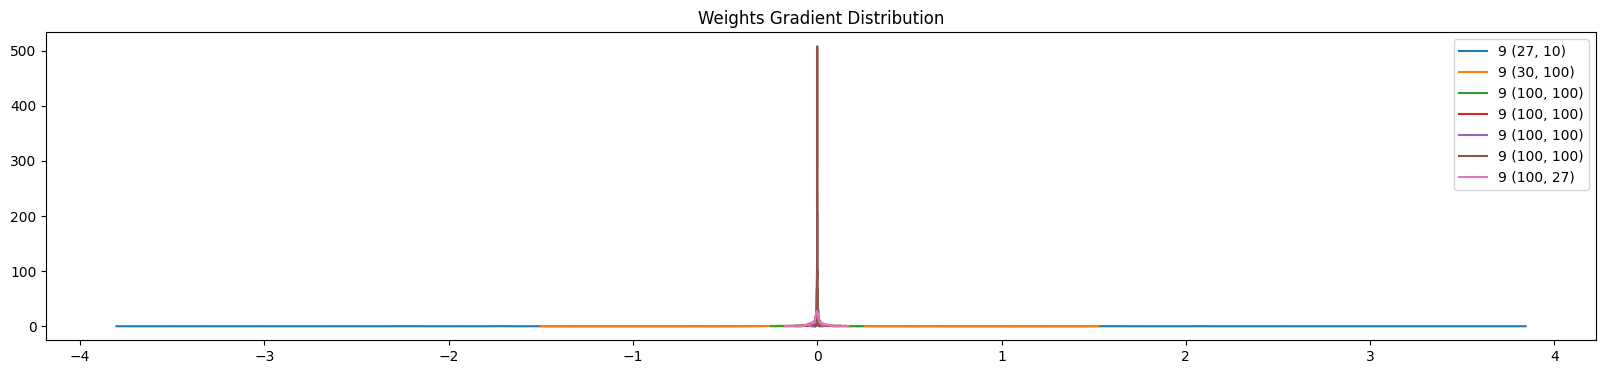

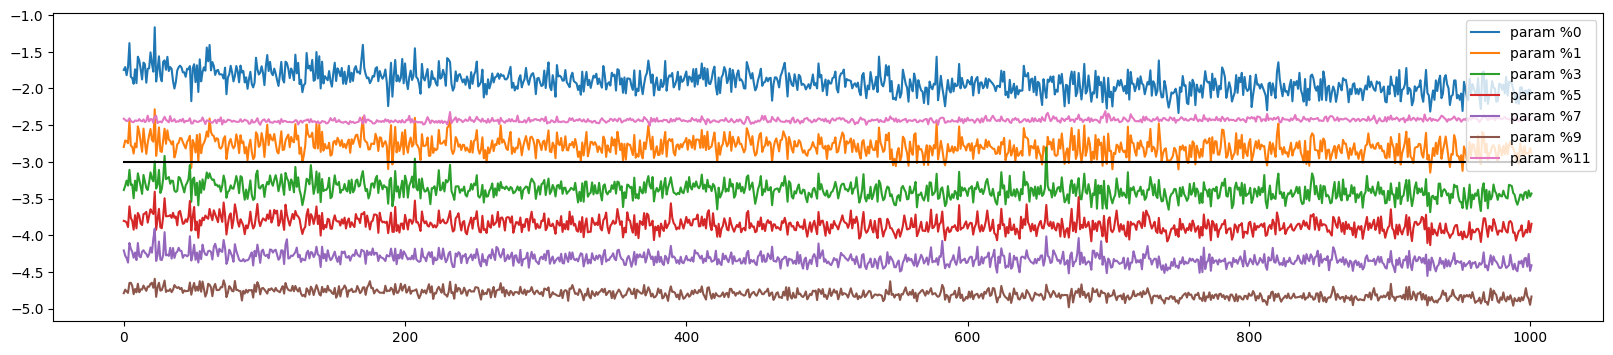

In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts)
    }[split]

    embed = C[x]
    x = embed.view(embed.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

for layer in layers:
    layer.training = False

split_loss('train')
split_loss('dev')

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(SEED)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        embed = C[torch.tensor([context])]
        x = embed.view(embed.shape[0], -1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=-1)

        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
    print(''.join(itos[i] for i in out))
